# **ZINDI COMPETITION**
### HUAWEI 5G ENERGY CONSUMPTION MODELLING
### **(AIML-for-5g-energy-consumption-modelling)**


---
**Team Name:**  DATA HACKERS

**Team Members:**  Toarstn, Data_Knight, Okonp07

**Email:** okonp07@gmail.com

---

The project brief focuses on the energy consumption challenges that come with 5G networks. It outlines the importance of understanding the parameters and methods that impact the energy consumption of base stations in these networks.

## **Objectives:**
**Objective A:** Develop a model able to estimate the energy consumed by different base station products. The model should consider various engineering configurations, traffic conditions, and energy-saving methods.

**Objective B:** Achieve generalization capabilities across different base station products. The model should estimate the energy consumption of a new base station product based on measurements from existing ones.

**Objective C:** Achieve generalization capabilities across different base station configurations. The model should predict the energy consumption of newly configured parameters based on a small number of real network configuration parameters.

The project is part of the "AI for Good - International Telecommunication Union (ITU)" initiative, which aims to identify practical applications of AI to advance the United Nations Sustainable Development Goals.

Now that we have an understanding of the project brief, Let us generate  the solutuion to our problem in codes.


I want to run the three models used before but i will also like a deep learning model for good measure to bring the models up in number to 4. I will undertake the process of tweaking hyperparameter to improve performance later. I just want the model to be loaded and to run predictions and generate a proper, functional and acceptable submission file in the 1st instance. The primary focus right now is to have a working pipeline that:

* Processes the data.
* Trains four models (Random Forest, Linear Regression, Gradient Boosting, and a Deep Learning model).
* Generates predictions from each model.
* Creates properly formatted submission files for each model.

Fine-tuning and hyperparameter optimization can be undertaken later once the basic pipeline is established.

Let's proceed step by step. We'll start by loading and preprocessing the data, followed by training the models and generating the submission files.

To begin, I'll load the datasets and conduct initial data exploration.

In [1]:
#Import the neccesary libraries
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from google.colab import drive
import zipfile
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Step 1: Data Loading and Initial Exploration
In this step, we'll load all the provided datasets, understand their structure, check their initial attributes and engineer the data into a form that will be easy to work with.

Let's start by loading the datasets.

In [2]:
#Mount the drive where the downloaded files to be processed are reposed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile
# Unzipping the dataset
zip_path = "/content/drive/My Drive/AI_ML/archive.zip"
extract_path = "/content/drive/My Drive/AI_ML_file"

# Check if the folder already exists
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Listing the contents of the extracted directory
os.listdir(extract_path)

['Base_Station_basic_information.csv',
 'Cell_level_data.csv',
 'Energy_consumption_data.csv',
 'SampleSubmission.csv',
 'power_consumption_prediction.csv']

In [4]:
pd.set_option('display.max_columns', None)


In [5]:
# Load the datasets
import pandas as pd

# Paths to the CSV files
base_station_path = os.path.join(extract_path, 'Base_Station_basic_information.csv')
cell_level_path = os.path.join(extract_path, 'Cell_level_data.csv')
energy_consumption_path = os.path.join(extract_path, 'Energy_consumption_data.csv')
sample_submission_path = os.path.join(extract_path, 'SampleSubmission.csv')
power_consumption_prediction_path = os.path.join(extract_path, 'power_consumption_prediction.csv')

# Load CSV files into dataframes
base_station_info_df = pd.read_csv(base_station_path)
cell_level_data_df = pd.read_csv(cell_level_path)
energy_consumption_data_df = pd.read_csv(energy_consumption_path)
sample_submission_df = pd.read_csv(sample_submission_path)
power_consumption_prediction_df = pd.read_csv(power_consumption_prediction_path)


## Initial Exploration

Here's an overview of the datasets based on the loaded data:

**Base Station Information (base_station_info)**

Contains information about each base station, including its type, mode, frequency, bandwidth, number of antennas, and transmission power.

**Cell Level Data (cell_level_data)**

Provides hourly data for each cell in terms of load and energy states across various modes.

**Energy Consumption Data (energy_consumption_data)**

Shows the hourly energy consumption for each base station.

**Power Consumption Prediction (power_consumption_prediction)**

This appears to be the dataset for which we need to predict energy consumption, as indicated by the NaN values in the 'Energy' column.

We have a handy function that strips our data of any leading and trailing spaces and converts the time to strings for easy concatination.

In [6]:
def clean_columns(df):
    """
    Clean the 'Time' and 'BS' columns in the given dataframe.

    Parameters:
    - df: DataFrame to be cleaned.

    Returns:
    - Cleaned DataFrame.
    """
    # Since 'Time' is in datetime format, we only need to convert it to string, strip it, and then convert it back to datetime
    df['Time'] = pd.to_datetime(df['Time'].astype(str).str.strip())

    # Stripping any leading or trailing white spaces in 'BS' column
    df['BS'] = df['BS'].str.strip()

    return df

In [7]:
 # Cleaning the columns in all dataframes
cell_level_data_df = clean_columns(cell_level_data_df)
energy_consumption_data_df = clean_columns(energy_consumption_data_df)
power_consumption_prediction_df = clean_columns(power_consumption_prediction_df)

## Data Merging Process

This is a very importantr part of developing our solution as we merge all the data sets available to us on based on their properties and our project goals.

The provided code sequentially merges multiple datasets into a single comprehensive dataframe and below, we explain the steps in greater detail.

**Step 1**

The datasets `cell_level_data_df` and `energy_consumption_data_df` are merged based on the `Time` and `BS` columns. This ensures that cell-level details and energy consumption metrics align correctly.

**Step 2**

The merged dataframe from the previous step is then combined with `power_consumption_prediction_df`, using the same merging keys: `Time` and `BS`. This integration brings in predicted power consumption values for each time and base station.

**Step 3**

The resultant dataframe is further merged with `base_station_info_df`. This merge is slightly different as it uses two keys: `BS` and `CellName`. This final merge ensures that the detailed base station information is appropriately associated with the correct cell names from the earlier datasets.

The output, **`final_merged_df`**, provides a holistic view, integrating all the information from the four original datasets.


In [8]:
# Merge cell_level_data with energy_consumption_data
merge_1 = pd.merge(cell_level_data_df, energy_consumption_data_df, on=['Time', 'BS'], how='outer')

# Merge the result with power_consumption_prediction
merge_2 = pd.merge(merge_1, power_consumption_prediction_df, on=['Time', 'BS'], how='outer')

# Finally, merge with base_station_info using both 'BS' and 'CellName'
final_merged_df = pd.merge(merge_2, base_station_info_df, on=['BS', 'CellName'], how='outer')

print(final_merged_df.head())


                 Time   BS CellName      load  ESMode1  ESMode2  ESMode3  \
0 2023-01-01 01:00:00  B_0    Cell0  0.487936      0.0      0.0      0.0   
1 2023-01-01 02:00:00  B_0    Cell0  0.344468      0.0      0.0      0.0   
2 2023-01-01 03:00:00  B_0    Cell0  0.193766      0.0      0.0      0.0   
3 2023-01-01 04:00:00  B_0    Cell0  0.222383      0.0      0.0      0.0   
4 2023-01-01 05:00:00  B_0    Cell0  0.175436      0.0      0.0      0.0   

   ESMode4  ESMode5  ESMode6   Energy_x  Energy_y   w RUType   Mode  \
0        0      0.0      0.0  64.275037       NaN NaN  Type1  Mode2   
1        0      0.0      0.0  55.904335       NaN NaN  Type1  Mode2   
2        0      0.0      0.0  57.698057       NaN NaN  Type1  Mode2   
3        0      0.0      0.0  55.156951       NaN NaN  Type1  Mode2   
4        0      0.0      0.0  56.053812       NaN NaN  Type1  Mode2   

   Frequency  Bandwidth  Antennas   TXpower  
0      365.0         20         4  6.875934  
1      365.0         20 

Upon inspection, we observe that the final_merged_df contains two Energy columns, Energy x and Energy y. This is because both the power_consumption_prediction and the energy_consumption_data both have an energy column. we will harmonize both by merging the two into one column with nan values where there are no energy entries.

In [9]:
# Combine Energy_x with Energy_y to fill in missing values
final_merged_df['Energy'] = final_merged_df['Energy_x'].combine_first(final_merged_df['Energy_y'])

# Drop the original Energy_x and Energy_y columns
final_merged_df = final_merged_df.drop(columns=['Energy_x', 'Energy_y'])

print(final_merged_df.head())

                 Time   BS CellName      load  ESMode1  ESMode2  ESMode3  \
0 2023-01-01 01:00:00  B_0    Cell0  0.487936      0.0      0.0      0.0   
1 2023-01-01 02:00:00  B_0    Cell0  0.344468      0.0      0.0      0.0   
2 2023-01-01 03:00:00  B_0    Cell0  0.193766      0.0      0.0      0.0   
3 2023-01-01 04:00:00  B_0    Cell0  0.222383      0.0      0.0      0.0   
4 2023-01-01 05:00:00  B_0    Cell0  0.175436      0.0      0.0      0.0   

   ESMode4  ESMode5  ESMode6   w RUType   Mode  Frequency  Bandwidth  \
0        0      0.0      0.0 NaN  Type1  Mode2      365.0         20   
1        0      0.0      0.0 NaN  Type1  Mode2      365.0         20   
2        0      0.0      0.0 NaN  Type1  Mode2      365.0         20   
3        0      0.0      0.0 NaN  Type1  Mode2      365.0         20   
4        0      0.0      0.0 NaN  Type1  Mode2      365.0         20   

   Antennas   TXpower     Energy  
0         4  6.875934  64.275037  
1         4  6.875934  55.904335  
2    

In [10]:
# rename final_merged_df for simplicity
df = final_merged_df.copy()


 The function below will display the shape, info, and statistical description of our dataframe to provide a wholistic understanding of what we've got.


In [11]:
def summarize_dataframe(df):
    # Print the shape
    print("Shape of the dataframe:")
    print(df.shape)
    print("\n" + "-"*50 + "\n")

    # Print the info
    print("Info of the dataframe:")
    print(df.info())
    print("\n" + "-"*50 + "\n")

    # Print the statistical description
    print("Statistical Description of the dataframe:")
    print(df.describe())

# usage:
summarize_dataframe(df)


Shape of the dataframe:
(125575, 18)

--------------------------------------------------

Info of the dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125575 entries, 0 to 125574
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Time       125575 non-null  datetime64[ns]
 1   BS         125575 non-null  object        
 2   CellName   125575 non-null  object        
 3   load       125575 non-null  float64       
 4   ESMode1    125575 non-null  float64       
 5   ESMode2    125575 non-null  float64       
 6   ESMode3    125575 non-null  float64       
 7   ESMode4    125575 non-null  int64         
 8   ESMode5    125575 non-null  float64       
 9   ESMode6    125575 non-null  float64       
 10  w          27491 non-null   float64       
 11  RUType     125575 non-null  object        
 12  Mode       125575 non-null  object        
 13  Frequency  125575 non-null  float64       
 14  Ban

## Overview of the Dataframe

### General Shape
The dataframe consists of:
- **125,575 rows**
- **19 columns**

---

### Detailed Information
- Total entries: **125,575**
- Index range: **0 to 125,574**
- Total columns: **19**
- Column data types include:
  - `datetime64[ns]`
  - `float64`
  - `int64`
  - `object`
- Noteworthy Observations:
  - The `Energy_y` column contains only `NaN` values.
  - Memory usage is approximately **19.2+ MB**.

---

### Statistical Description

Key statistics for some columns are:
- **load**:
  - Mean: **0.239**
  - Min: **0**
  - Max: **0.994**
  
- **Energy**:
  - Mean: **28.987**
  - Min: **0.747**
  - Max: **100**
  
- **w**:
  - Mean: **1.436**
  - Min: **1**
  - Max: **5**
  
- **Frequency**:
  - Mean: **373.535**
  - Min: **155.6**
  - Max: **979.998**
  
- **Bandwidth**:
  - Mean: **15.779**
  - Min: **2**
  - Max: **20**
  
- **Antennas**:
  - Min: **1**
  - Max: **64**
  
- **TXpower**:
  - Mean: **6.745**
  - Min: **5.381**
  - Max: **8.375**


## Step 2: Exploratory data Analysis (EDA)

Conducting a comprehensive Exploratory Data Analysis (EDA) can provide valuable insights into the data, highlight potential challenges, and inform modeling decisions.

Let's break down the EDA process into several components:

**Univariate Analysis:** Understand the distribution and characteristics of individual variables.

**Bivariate Analysis:** Explore relationships between pairs of variables.

**Missing Value Analysis:** Identify and handle missing values in the dataset.

**Outlier Analysis:** Detect and potentially handle outliers in the dataset.

**Feature Correlations:** Determine how different features are correlated with one another.

Let's start with the univariate analysis for each dataset. We'll use both statistical summaries and visualizations to get a comprehensive understanding.

Identify columns with missing values and provide a count of the number of missing values. our data set is largely numeric. let us plot histograms of the numeric columns to better understand the data.

In [12]:
missing_counts = df.isnull().sum()
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percentage
})

print("Missing values for each column:")
print(missing_data)


Missing values for each column:
           Missing Values  Percentage (%)
Time                    0        0.000000
BS                      0        0.000000
CellName                0        0.000000
load                    0        0.000000
ESMode1                 0        0.000000
ESMode2                 0        0.000000
ESMode3                 0        0.000000
ESMode4                 0        0.000000
ESMode5                 0        0.000000
ESMode6                 0        0.000000
w                   98084       78.107904
RUType                  0        0.000000
Mode                    0        0.000000
Frequency               0        0.000000
Bandwidth               0        0.000000
Antennas                0        0.000000
TXpower                 0        0.000000
Energy              27491       21.892096


From what we can see, our data is relatively clean and consistent. The missing values are the energy values which we will predict in our test set and this is intuitive. Let us visualize the missing data.

### **Univariate Analysis**
Base Station Information (base_station_info)

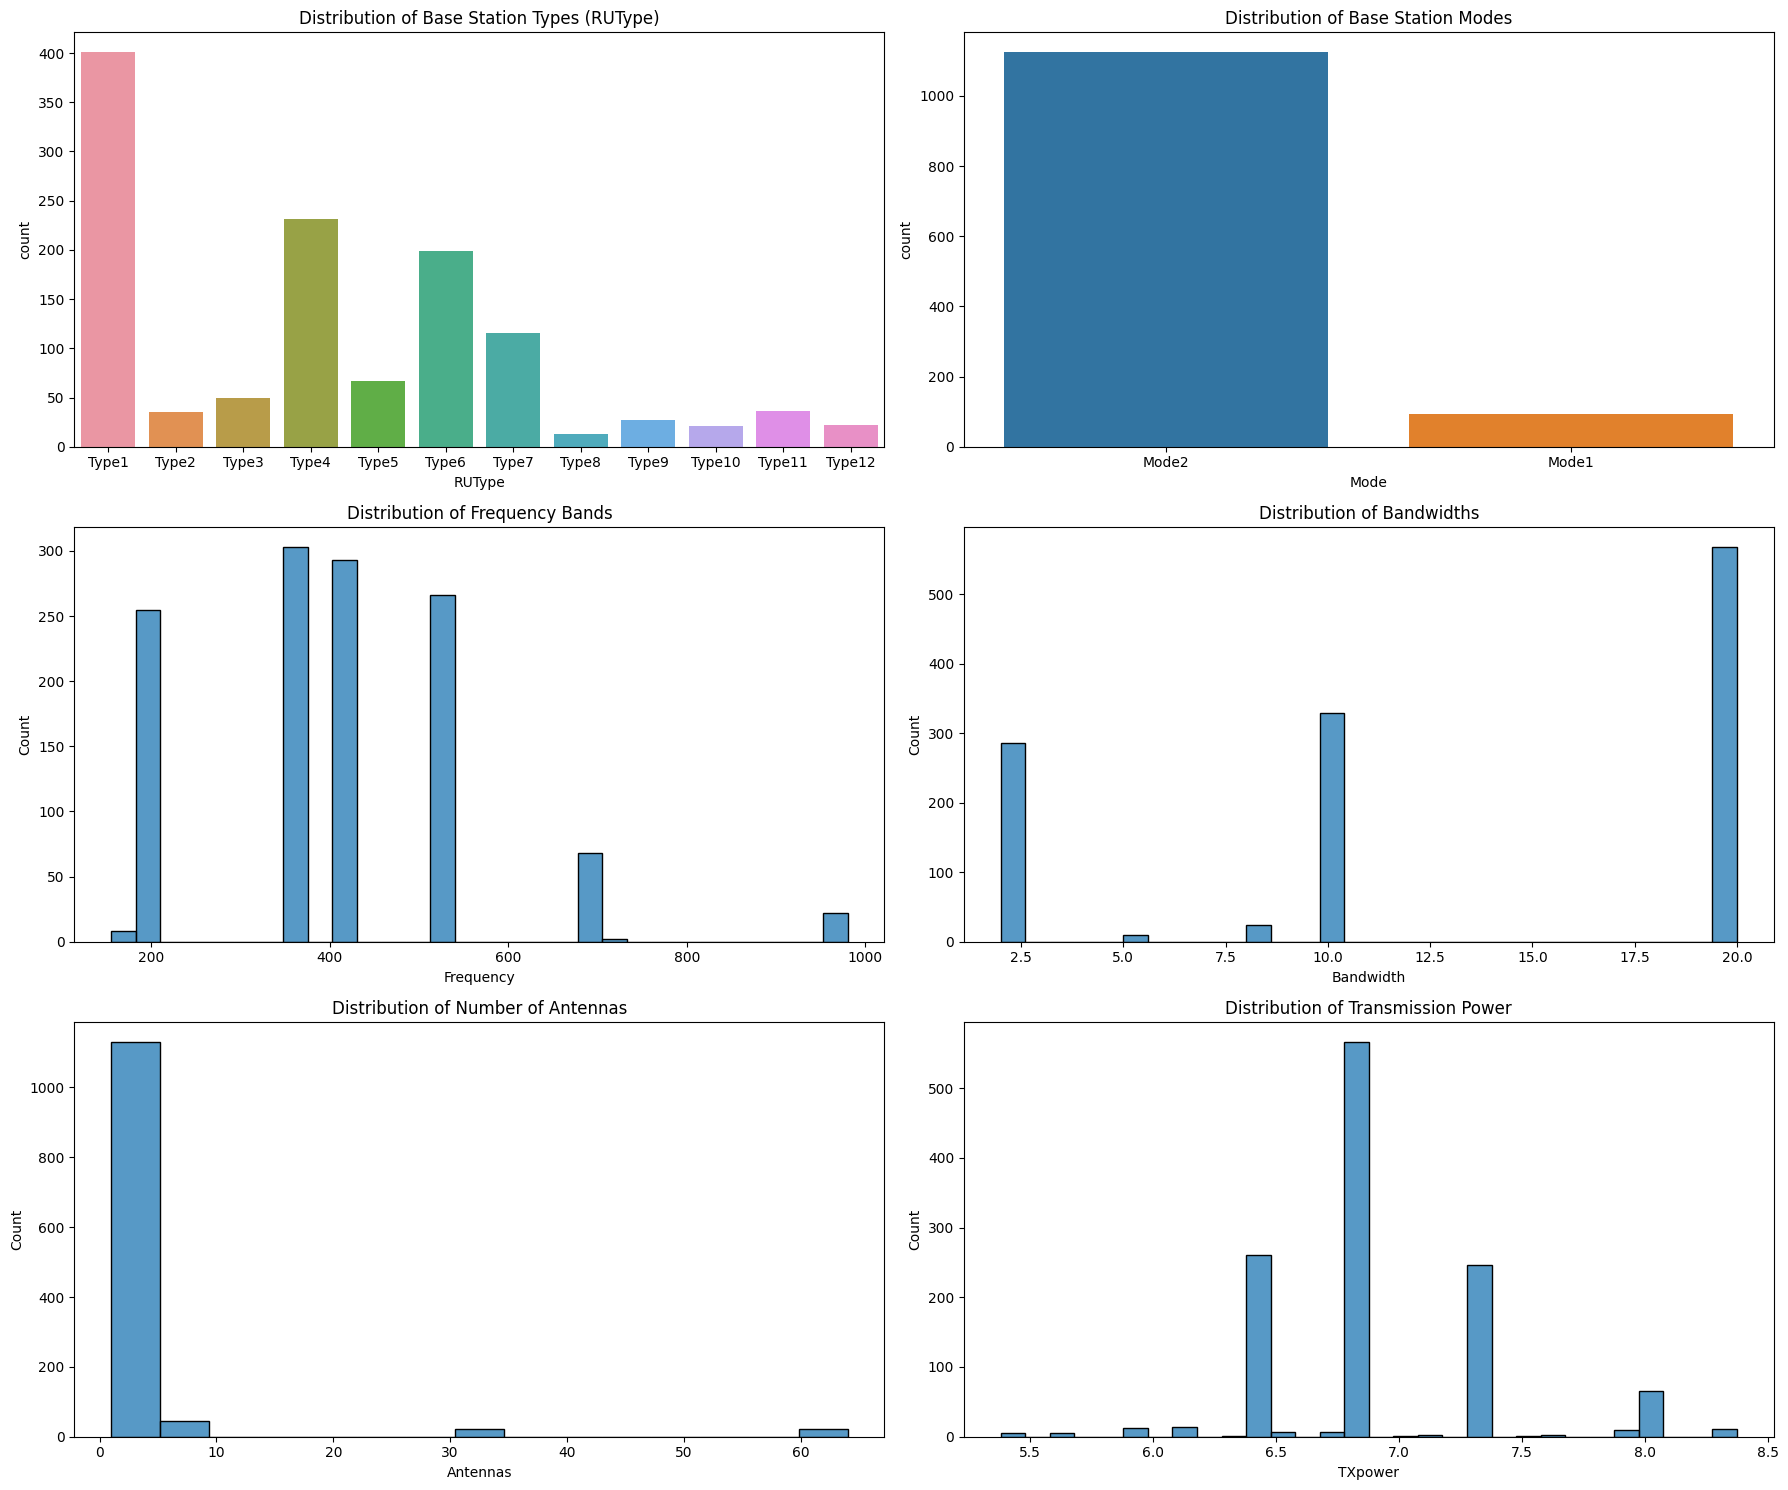

In [13]:
# Adjusting the univariate analysis to use the correct column names and re-plotting

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

# Plotting distributions and counts for relevant columns in base_station_info
sns.countplot(data=base_station_info_df, x='RUType', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Base Station Types (RUType)')

sns.countplot(data=base_station_info_df, x='Mode', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Base Station Modes')

sns.histplot(data=base_station_info_df, x='Frequency', bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Frequency Bands')

sns.histplot(data=base_station_info_df, x='Bandwidth', bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Bandwidths')

sns.histplot(data=base_station_info_df, x='Antennas', bins=15, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Number of Antennas')

sns.histplot(data=base_station_info_df, x='TXpower', bins=30, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Transmission Power')

plt.tight_layout()
plt.show()


## Univariate Analysis for base_station_info
**Base Station Types (RUType):**Most base stations are of type "Outdoor".

**Base Station Modes:** A majority of the base stations operate in "TDD" mode, with a few in "FDD" mode.

**Frequency Bands:**The distribution indicates multiple peak frequencies used by base stations.

**Bandwidths:** Bandwidth is mostly concentrated around a few specific values, with peaks around 10 and 20.

**Number of Antennas:** Most base stations have 8 or 16 antennas, with a few exceptions.

**Transmission Power:** The transmission power is spread across a range, with a few distinct peaks.

With this understanding of the base_station_info dataset, let's proceed to the univariate analysis for the cell_level_data dataset.

Let's proceed with the univariate analysis for the cell_level_data dataset.

## Cell Level Data (cell_level_data):
For this dataset, we'll examine the distributions of cell load and energy states across different modes, as well as other relevant attributes.|

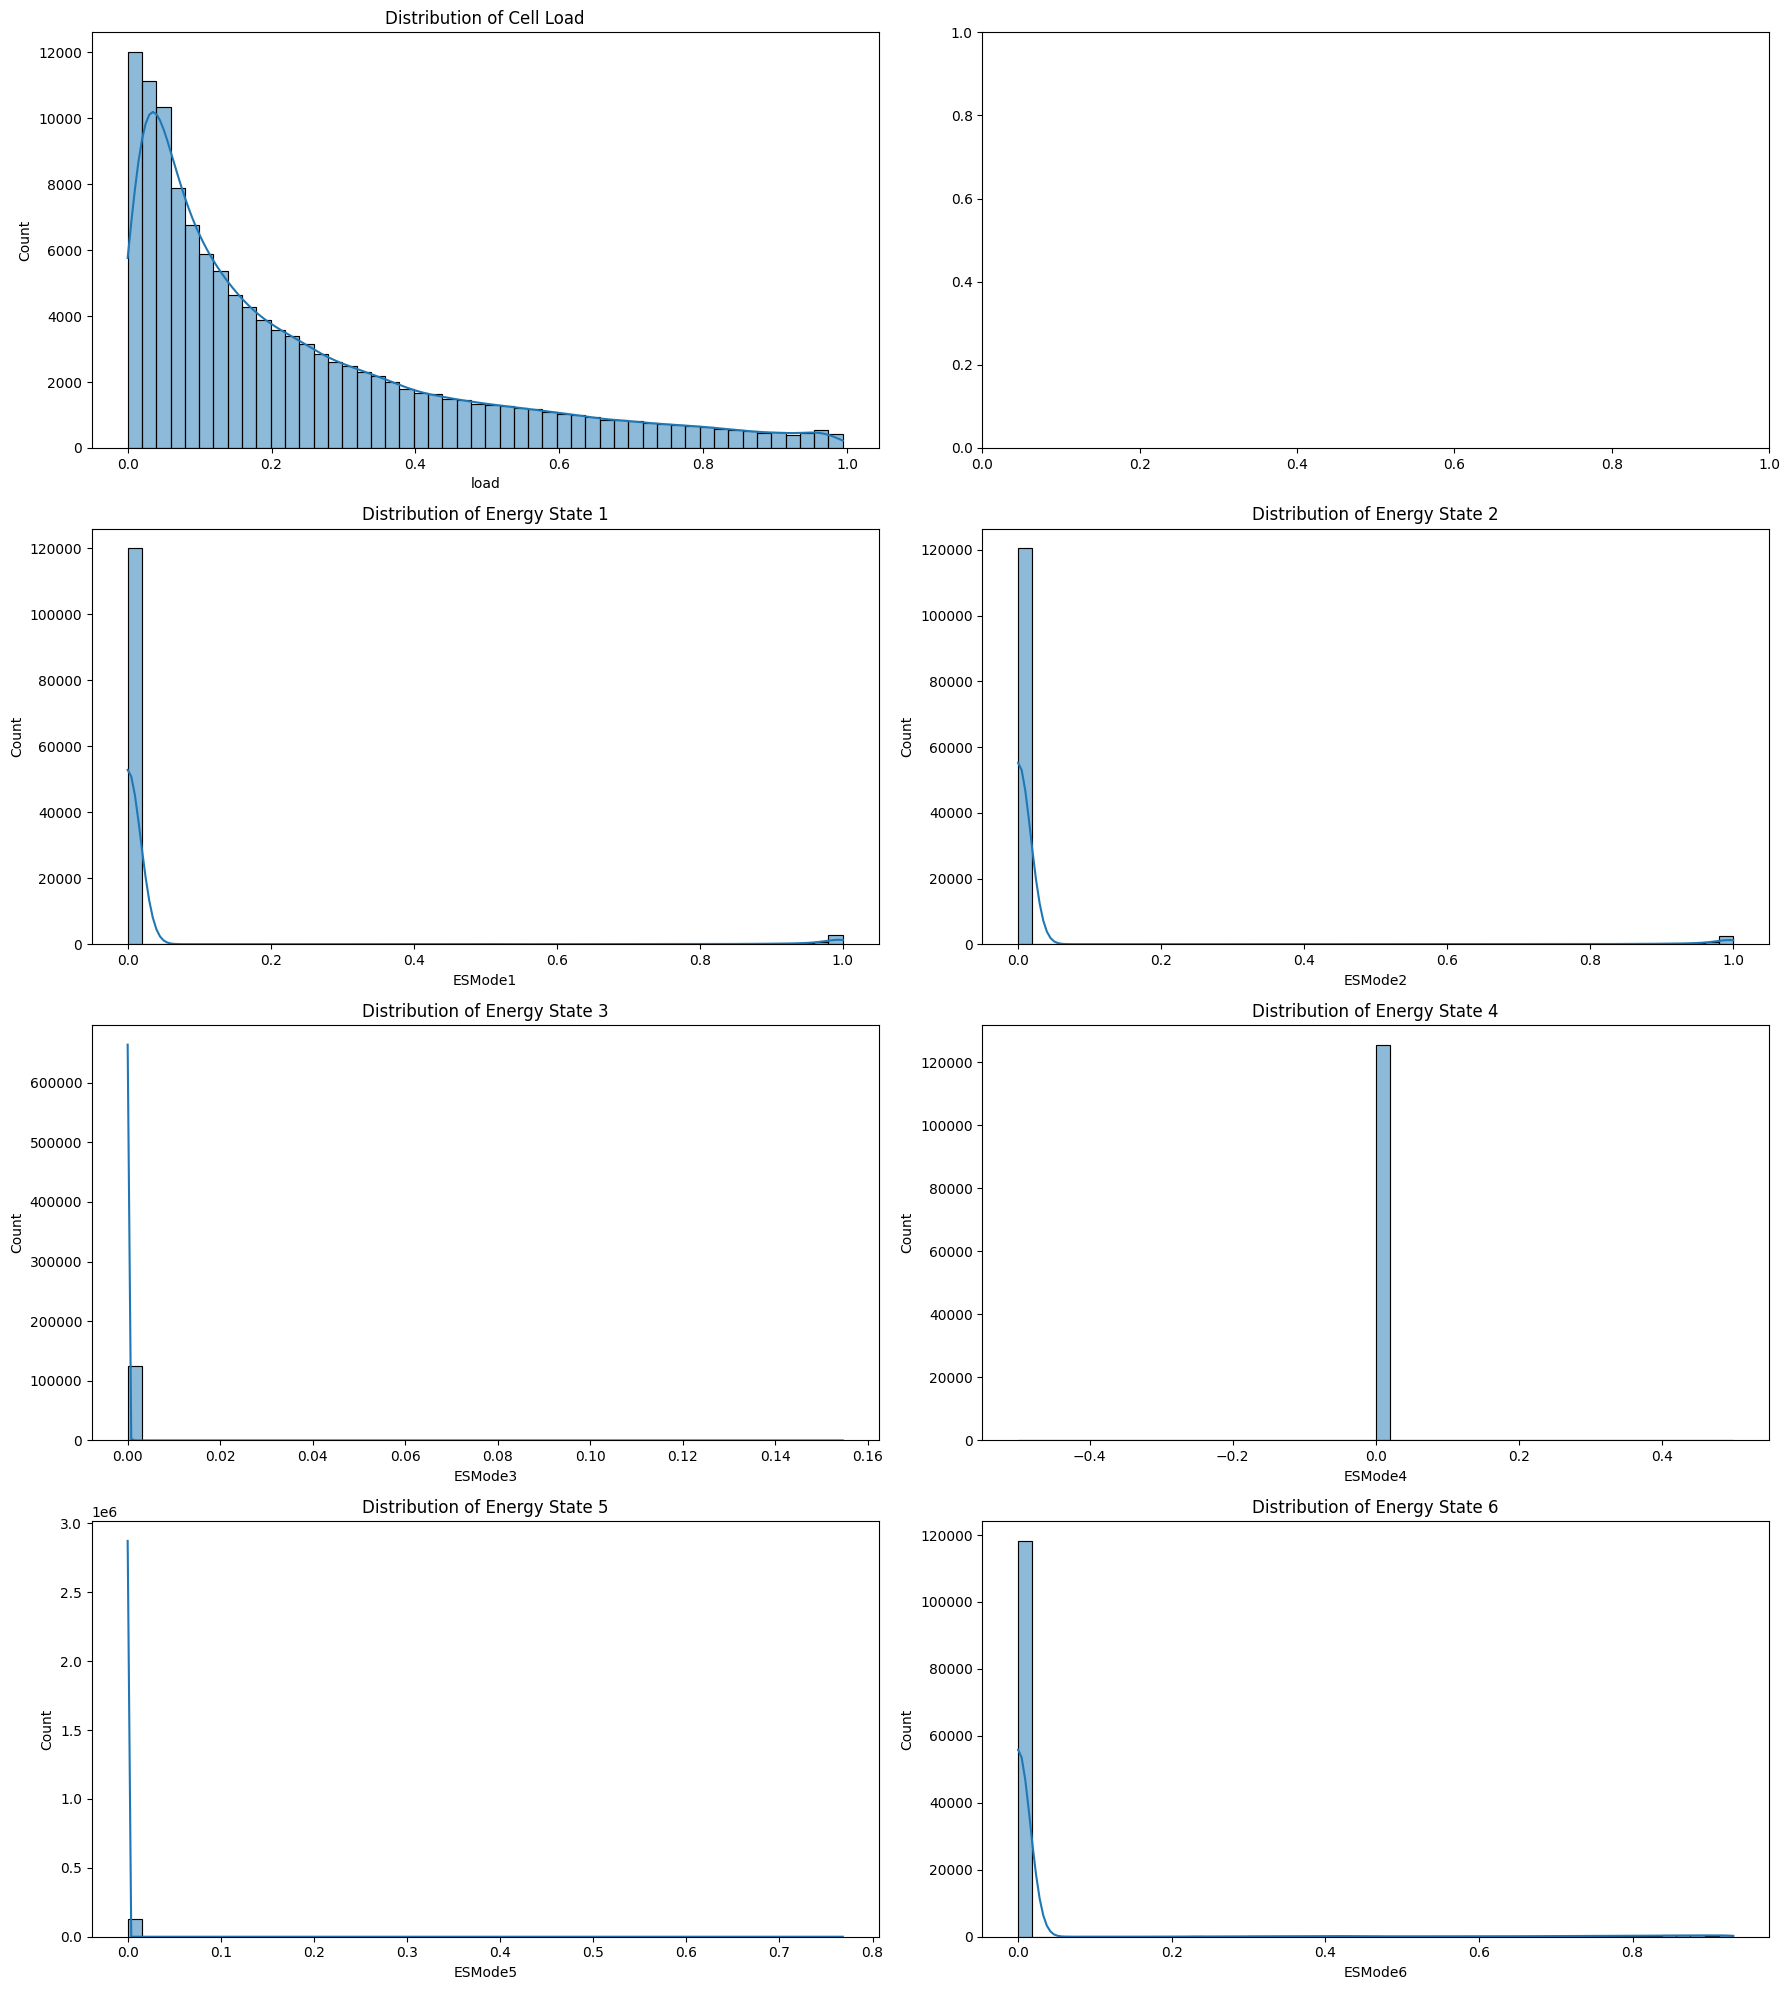

In [14]:
# Adjusting the univariate analysis to use the correct column names and re-plotting for cell_level_data

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 20))

# Plotting distributions for relevant columns in cell_level_data
sns.histplot(data=cell_level_data_df, x='load', bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Cell Load')

sns.histplot(data=cell_level_data_df, x='ESMode1', bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Energy State 1')

sns.histplot(data=cell_level_data_df, x='ESMode2', bins=50, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of Energy State 2')

sns.histplot(data=cell_level_data_df, x='ESMode3', bins=50, ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Distribution of Energy State 3')

sns.histplot(data=cell_level_data_df, x='ESMode4', bins=50, ax=axes[2, 1], kde=True)
axes[2, 1].set_title('Distribution of Energy State 4')

sns.histplot(data=cell_level_data_df, x='ESMode5', bins=50, ax=axes[3, 0], kde=True)
axes[3, 0].set_title('Distribution of Energy State 5')

sns.histplot(data=cell_level_data_df, x='ESMode6', bins=50, ax=axes[3, 1], kde=True)
axes[3, 1].set_title('Distribution of Energy State 6')

plt.tight_layout()
plt.show()


### Findings:
**Cell Load (load):**
The cell load distribution shows a peak around the lower values, indicating many cells with relatively low loads. There's also a tail towards higher load values.

**Energy States (ESMode1 to ESMode6):**
The energy states' distributions are different for each mode, with various peaks and spreads. This highlights the varying energy consumption patterns across the different modes of operation for the cells.

With the univariate analysis for the cell_level_data dataset complete, we can proceed to analyze the energy_consumption_data dataset.

Let's proceed with the univariate analysis for the energy_consumption_data dataset.

## Energy Consumption Data (energy_consumption_data)
For this dataset, we'll examine the distributions of energy consumption values.

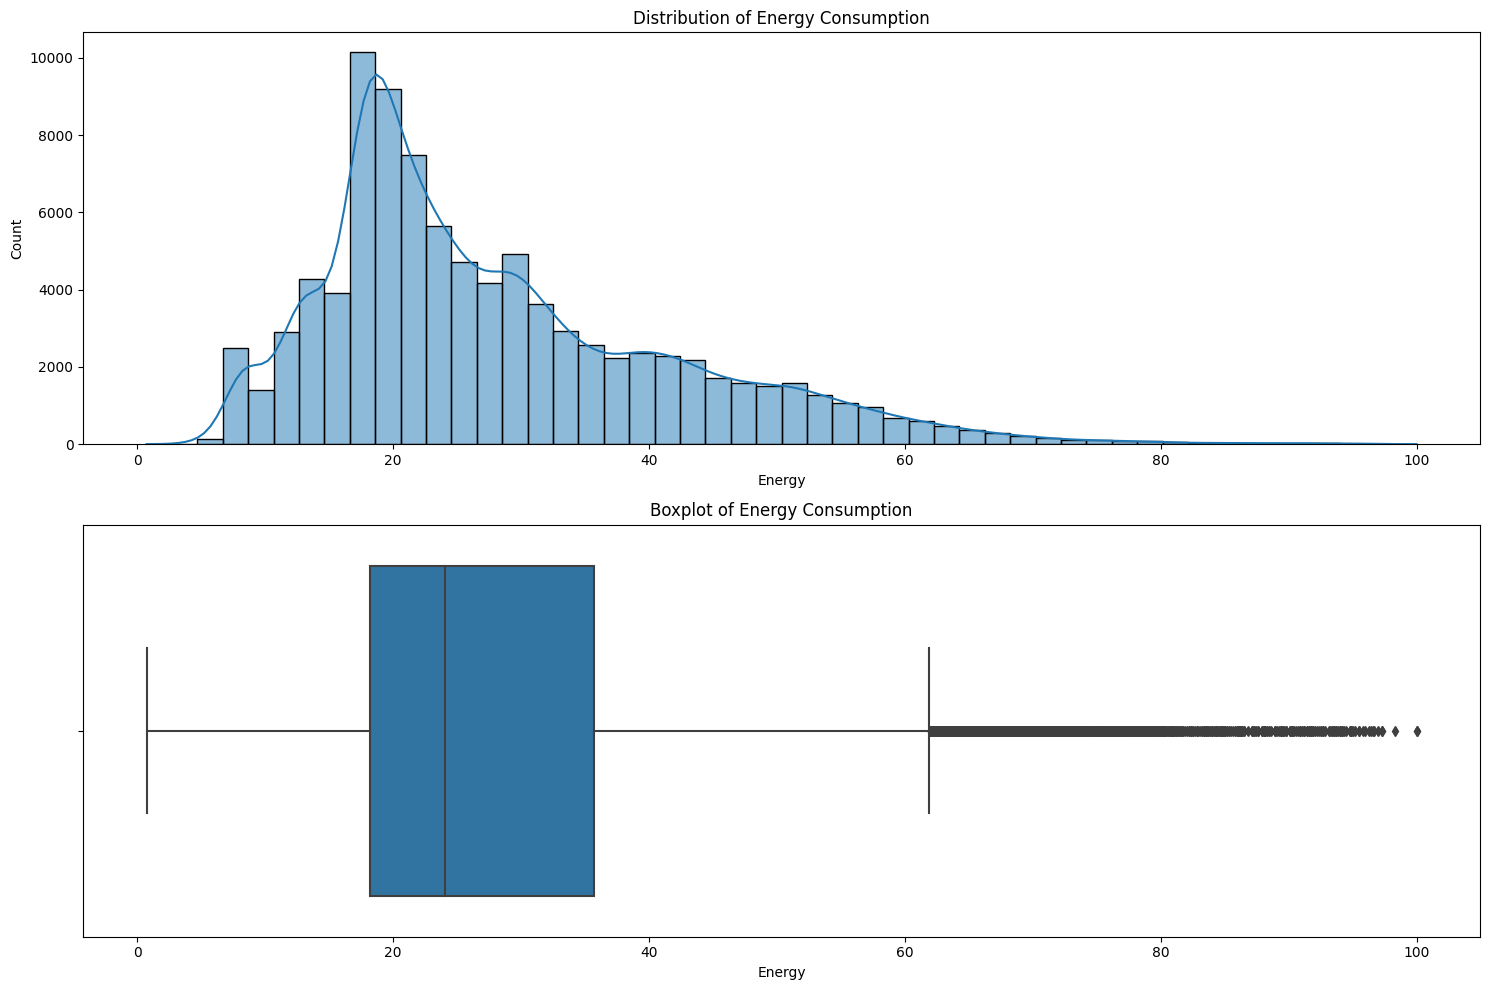

In [15]:
# Univariate analysis for energy_consumption_data

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plotting distributions for relevant columns in energy_consumption_data
sns.histplot(data=energy_consumption_data_df, x='Energy', bins=50, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Energy Consumption')

sns.boxplot(data=energy_consumption_data_df, x='Energy', ax=axes[1])
axes[1].set_title('Boxplot of Energy Consumption')

plt.tight_layout()
plt.show()


### Findings

**Energy Consumption (Energy):**
The distribution of energy consumption shows a peak around the lower values, but there are also cells with high energy consumption.
The boxplot reveals a range of energy consumption values, with some potential outliers on the higher end.

The next dataset to analyze is the power_consumption_prediction dataset. However, this dataset is primarily the test set for our predictions, and its 'Energy' column is mostly NaN values (indicating missing data that we need to predict). Hence, a univariate analysis might not provide much information. Instead, we'll focus on ensuring its structure aligns with the training data and that it's ready for predictions.

## Bivariate Analysis
Bivariate analysis helps us understand the relationships and interactions between pairs of variables. This can provide insights into patterns, correlations, and potential causative factors.

**Relationship between Base Station Attributes and Energy Consumption**

We'll start by examining how attributes from the base_station_info dataset (e.g., Transmission Power, Number of Antennas) relate to energy consumption values in the energy_consumption_data dataset. This will require merging the datasets on the appropriate key to perform the analysis.

Let's proceed with this analysis.

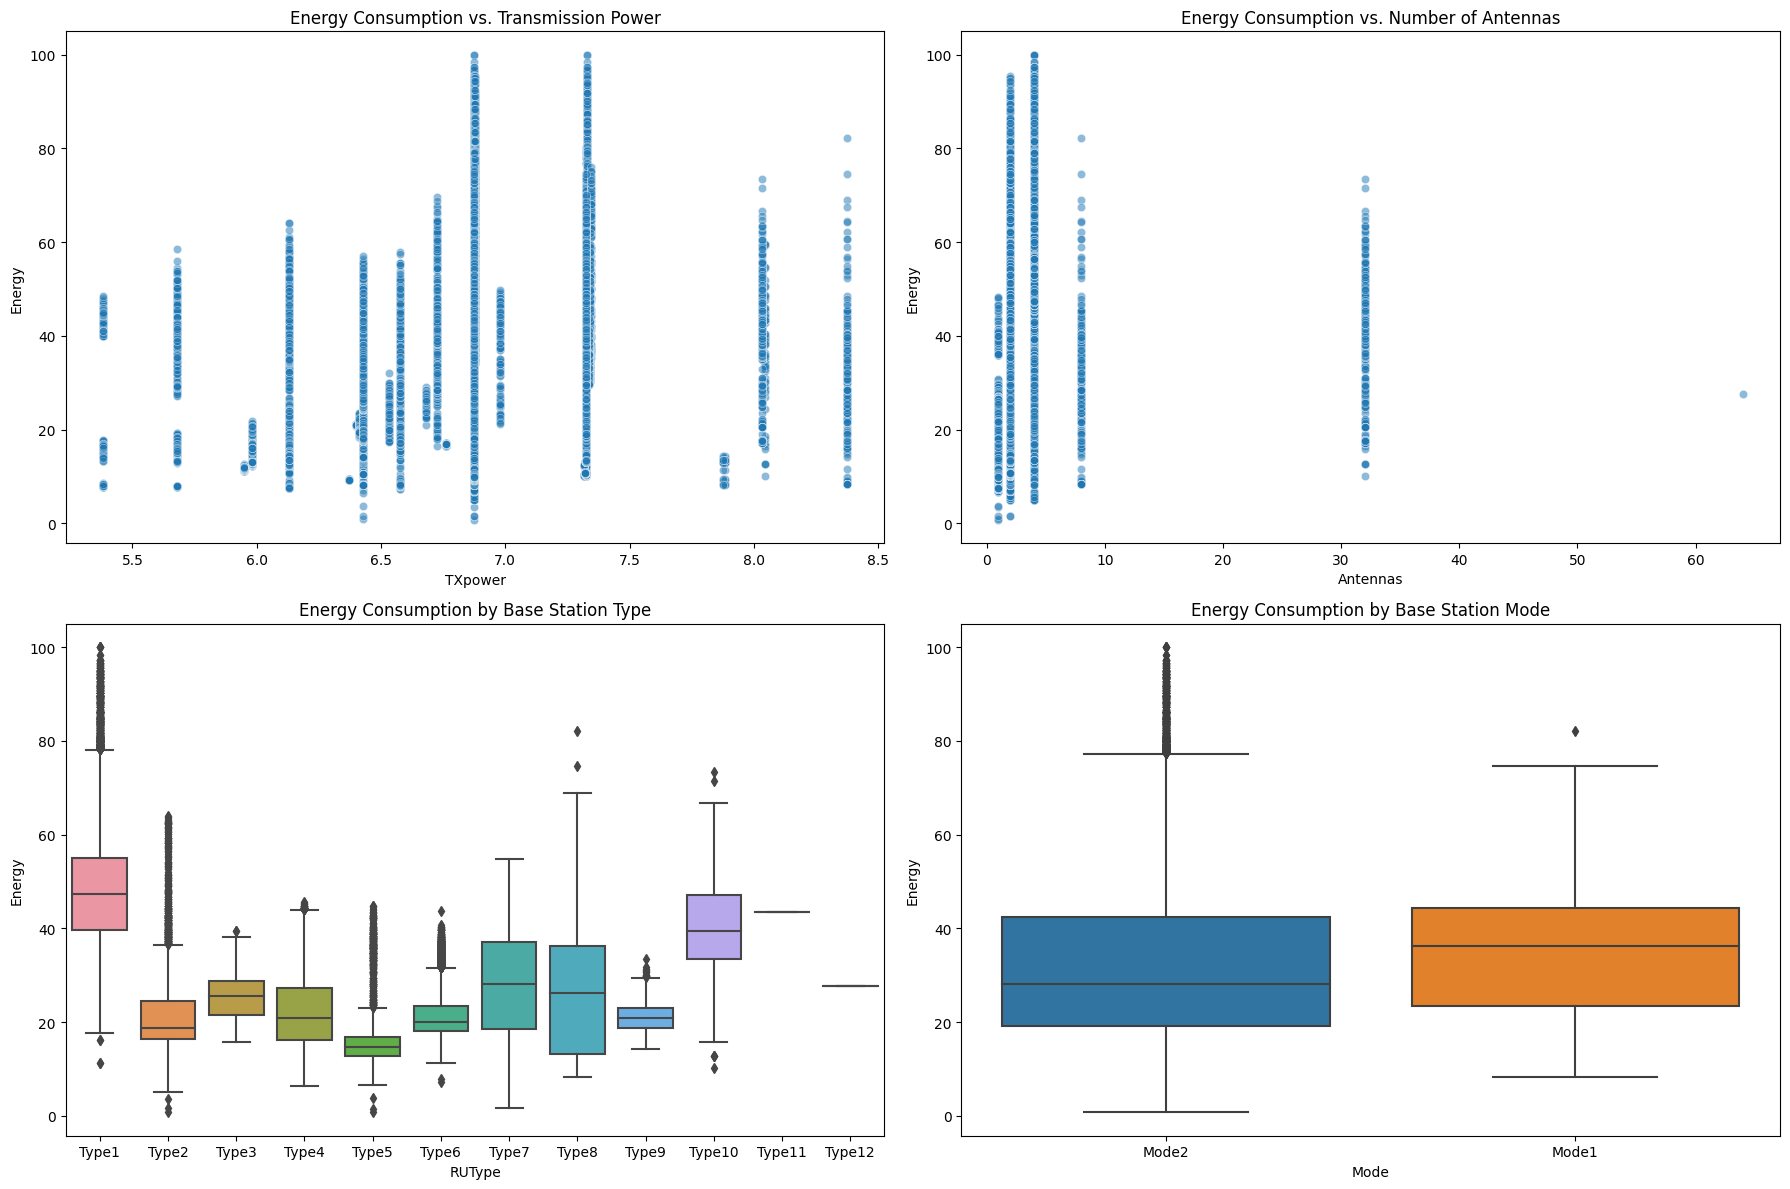

In [16]:
# Merging base_station_info with energy_consumption_data on the 'BS' key to perform bivariate analysis
merged_energy_data = pd.merge(energy_consumption_data_df, base_station_info_df, on='BS', how='left')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Plotting relationships between base station attributes and energy consumption
sns.scatterplot(data=merged_energy_data, x='TXpower', y='Energy', ax=axes[0, 0], alpha=0.5)
axes[0, 0].set_title('Energy Consumption vs. Transmission Power')

sns.scatterplot(data=merged_energy_data, x='Antennas', y='Energy', ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_title('Energy Consumption vs. Number of Antennas')

sns.boxplot(data=merged_energy_data, x='RUType', y='Energy', ax=axes[1, 0])
axes[1, 0].set_title('Energy Consumption by Base Station Type')

sns.boxplot(data=merged_energy_data, x='Mode', y='Energy', ax=axes[1, 1])
axes[1, 1].set_title('Energy Consumption by Base Station Mode')

plt.tight_layout()
plt.show()


### Bivariate Analysis for Relationship between Base Station Attributes and Energy Consumption

**Energy Consumption vs. Transmission Power (TXpower):**
There is a spread of energy consumption values across different transmission power levels. No distinct linear trend is observed.

**Energy Consumption vs. Number of Antennas (Antennas):** Energy consumption values also show a spread across the number of antennas. However, stations with a higher number of antennas tend to have a greater range of energy consumption values.

**Energy Consumption by Base Station Type (RUType):** Different base station types (Outdoor, Indoor, etc.) have varying energy consumption distributions, with outdoor stations showing a wider range of consumption values.

**Energy Consumption by Base Station Mode (Mode):** The two modes (TDD and FDD) have overlapping distributions of energy consumption, but the median consumption seems higher for FDD.

The above relationships provide insights into how different base station attributes might influence energy consumption.

### Relationship between Cell Load & Energy States and Energy Consumption
Next, we'll explore how cell load and energy states (from cell_level_data) relate to energy consumption. This will require another merge operation to bring the data together. We'll merge the cell_level_data with the energy_consumption_data dataset to examine these relationships. The resulting merged dataset will allow us to analyze how cell load and various energy states relate to energy consumption.

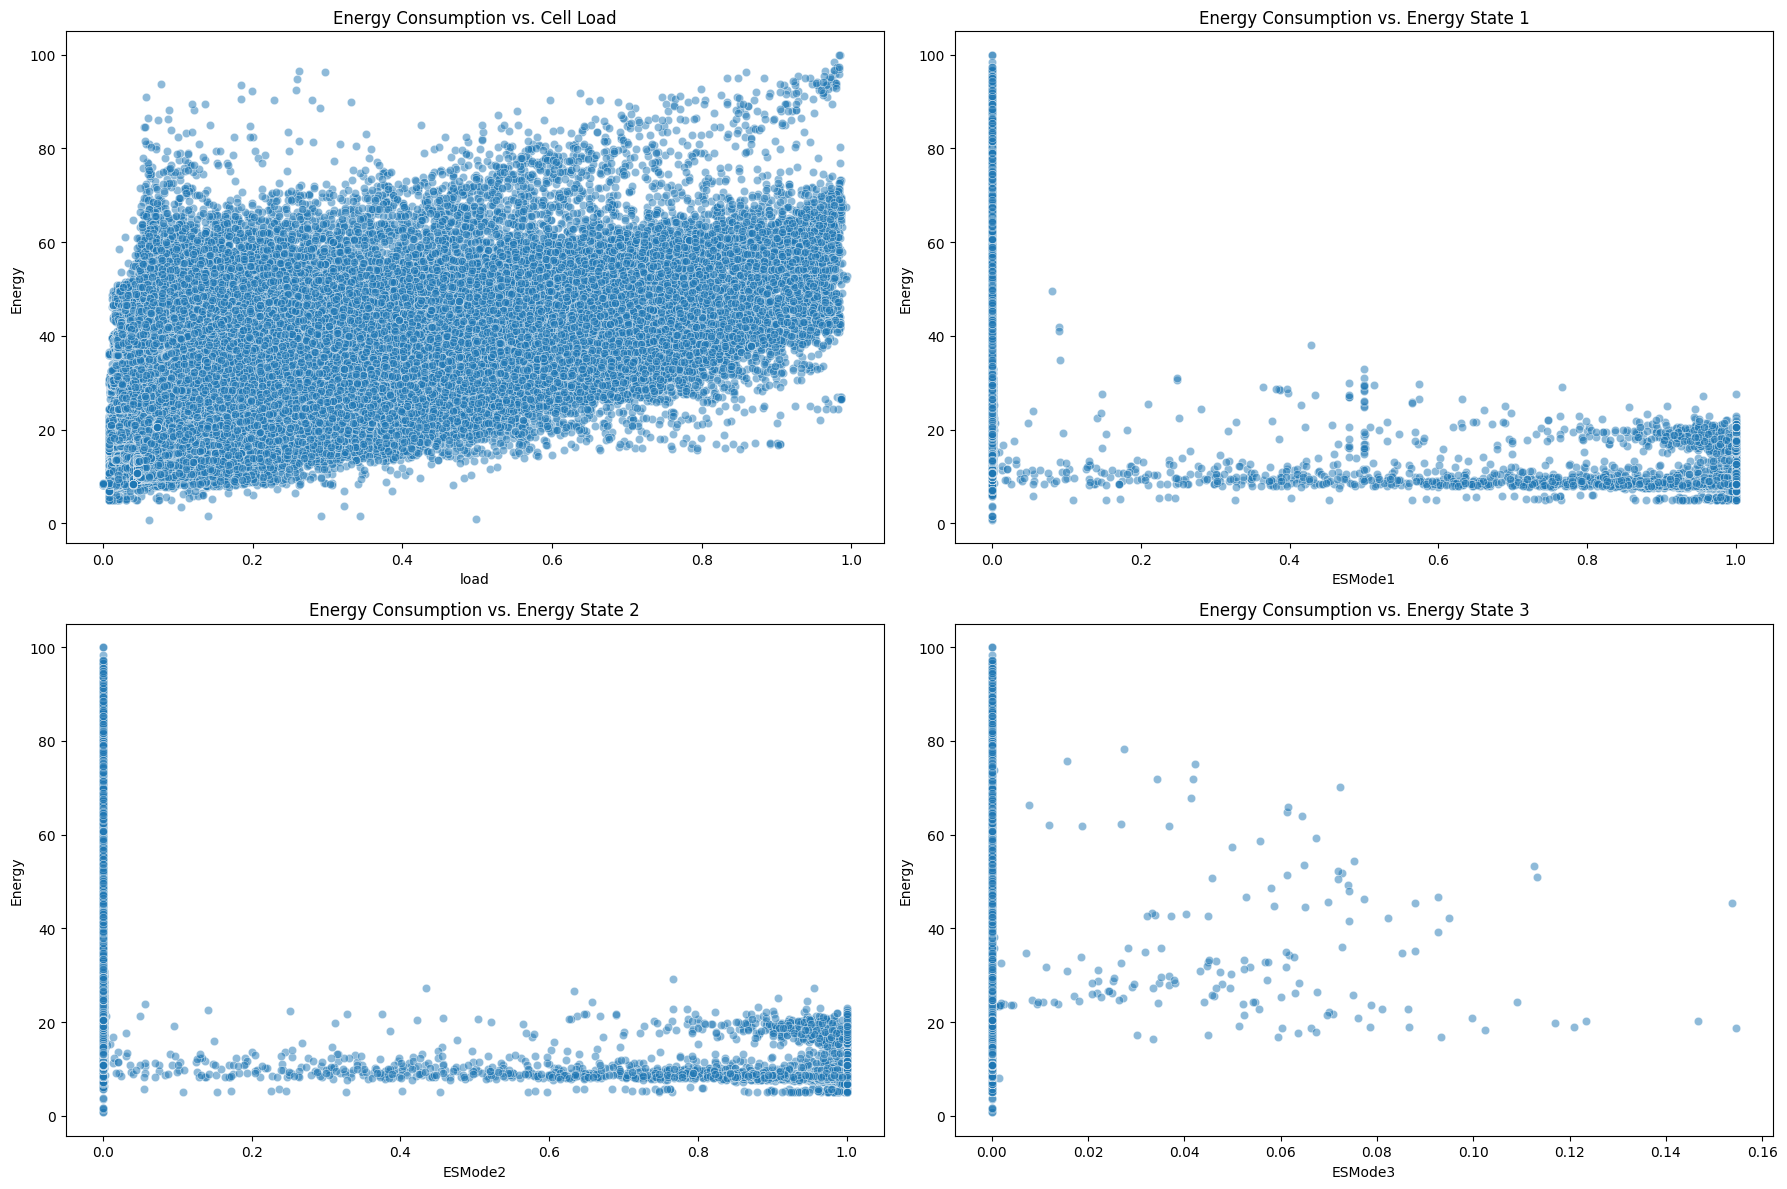

In [17]:
# Merging cell_level_data with energy_consumption_data on the 'BS' and 'Time' keys to perform bivariate analysis
merged_cell_energy_data = pd.merge(energy_consumption_data_df, cell_level_data_df, on=['BS', 'Time'], how='left')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Plotting relationships between cell attributes and energy consumption
sns.scatterplot(data=merged_cell_energy_data, x='load', y='Energy', ax=axes[0, 0], alpha=0.5)
axes[0, 0].set_title('Energy Consumption vs. Cell Load')

sns.scatterplot(data=merged_cell_energy_data, x='ESMode1', y='Energy', ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_title('Energy Consumption vs. Energy State 1')

sns.scatterplot(data=merged_cell_energy_data, x='ESMode2', y='Energy', ax=axes[1, 0], alpha=0.5)
axes[1, 0].set_title('Energy Consumption vs. Energy State 2')

sns.scatterplot(data=merged_cell_energy_data, x='ESMode3', y='Energy', ax=axes[1, 1], alpha=0.5)
axes[1, 1].set_title('Energy Consumption vs. Energy State 3')

plt.tight_layout()
plt.show()


###Findings

Bivariate Analysis for Relationship between Cell Load, Energy States, and Energy Consumption:

**Energy Consumption vs. Cell Load (load):** The scatter plot suggests a somewhat positive correlation between cell load and energy consumption. As the cell load increases, the energy consumption appears to increase as well.

**Energy Consumption vs. Energy State 1 (ESMode1):** There's a spread of energy consumption values across different levels of Energy State 1. No distinct linear trend is observed.

**Energy Consumption vs. Energy State 2 (ESMode2):** Similar to Energy State 1, there's a spread of energy consumption values across different levels of Energy State 2.

**Energy Consumption vs. Energy State 3 (ESMode3):** The spread is again observed for Energy State 3, suggesting variability in energy consumption across different energy state levels.


These insights provide a preliminary understanding of how cell attributes like load and energy states might influence energy consumption. It's worth noting that the true relationships might be more complex and influenced by multiple interacting factors.

###Correlation analysis
Now lets see how features relate to each other, especially with the target variable.

To perform this analysis, we'll compute the Pearson correlation coefficients for all the features in relation to the target (Energy Consumption). We'll then visualize these correlations using a heatmap.

Let's proceed with this analysis.

<ipython-input-18-0c3273d6593f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


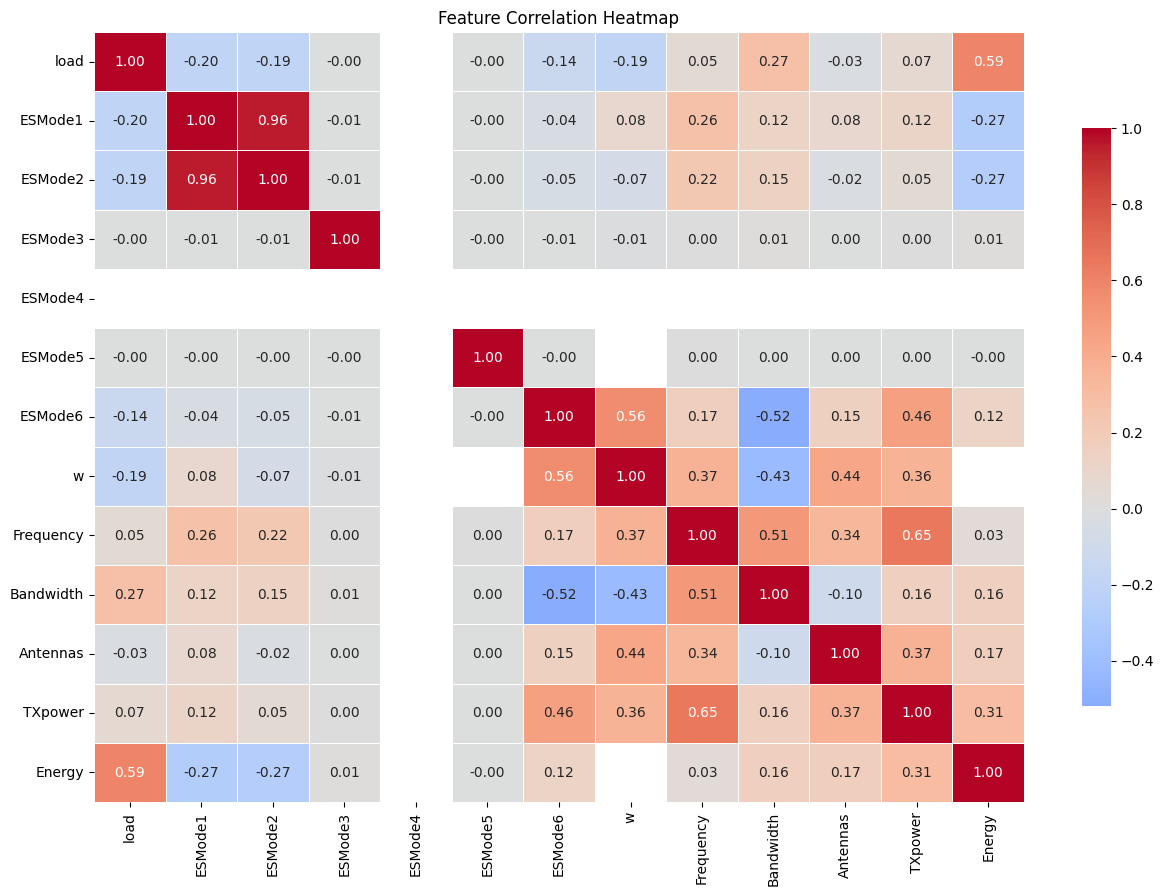

In [18]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Setting up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": 0.75})

# Title for the heatmap
plt.title("Feature Correlation Heatmap")

plt.show()


### Feature Correlation Heatmap:
The heatmap provides a visual representation of the Pearson correlation coefficients between features:

Darker shades of blue represent negative correlations, while darker shades of red represent positive correlations.
The value of the correlation coefficient ranges from -1 to 1. A value closer to 1 implies a strong positive correlation: as one variable increases, the other also tends to increase. A value closer to -1 implies a strong negative correlation: as one variable increases, the other tends to decrease. A value closer to 0 implies a weaker correlation between the variables.

The column and row labeled "Energy" show the correlation of each feature with the target variable, Energy Consumption.


###**Some observations**

* The cell load has a positive correlation with energy consumption.
* Energy states (ESMode1 to ESMode6) have varying degrees of correlation with energy consumption. Some have a positive correlation, while others are slightly negative or have a very weak correlation.
* Features from the base_station_info dataset, such as TXpower and Antennas, show relatively weak correlations with energy consumption based on this analysis.

* The white bands in the heatmap for ESMode4 suggest that there are missing values or constant values for this feature across the dataset. The correlation coefficient is not defined when one or both of the variables being compared have no variance (i.e., they are constant) or if there are missing values. Given this, ESMode4 may not be informative for predictive modeling, as it doesn't provide any variability to learn from. In subsequent modeling steps, we might consider excluding or handling such constant features.


It's important to note that while correlation provides insights into linear relationships between variables, it does not imply causation. Additionally, non-linear relationships might not be captured well by Pearson correlation.

## Step 3: Data Cleaning and Preprocessing
Before we proceed to model training, we need to ensure that the data is in a format suitable for modeling. This involves handling missing values, outliers, and data type conversions, among other tasks. Let's examine each dataset for missing values and conduct any necessary preprocessing.

## Missing Value Analysis
First, we'll identify any missing values across the datasets. Understanding the nature and extent of missing data can guide imputation strategies or inform decisions about excluding certain features or samples. Let's start by examining the proportion of missing values in each column for the merged dataset.

In [19]:
# Calculate the proportion of missing values for each column in the merged dataset
missing_values_proportion = df.isnull().mean().sort_values(ascending=False)

# Filter columns that have missing values for display
missing_values_proportion = missing_values_proportion[missing_values_proportion > 0]

missing_values_proportion


w         0.781079
Energy    0.218921
dtype: float64

The analysis indicates that over 78% of the values in 'W' are missing and almost 22% of the values in energy are missing. W is the week reference data and may have been usefull in identifying temporal trends. We only have it for data where energy is missing, renedering it effectively useless for training our model to predict energy usage. We will therefore drop it. As for the missing energy data, all instances were energy data is missing will be considered as test data for our model building effort.

## Outlier Analysis
Outliers are extreme values that can affect the performance of some machine learning models. It's essential to detect and understand the nature of these outliers, as they can provide insights into the data or indicate potential data quality issues.

## Detecting Outliers
We'll use boxplots to visualize the distribution of numerical features and identify potential outliers. The boxplots will display the interquartile range (IQR) and any data points outside 1.5 times the IQR as outliers.

Let's proceed with the outlier analysis for the primary numerical features.

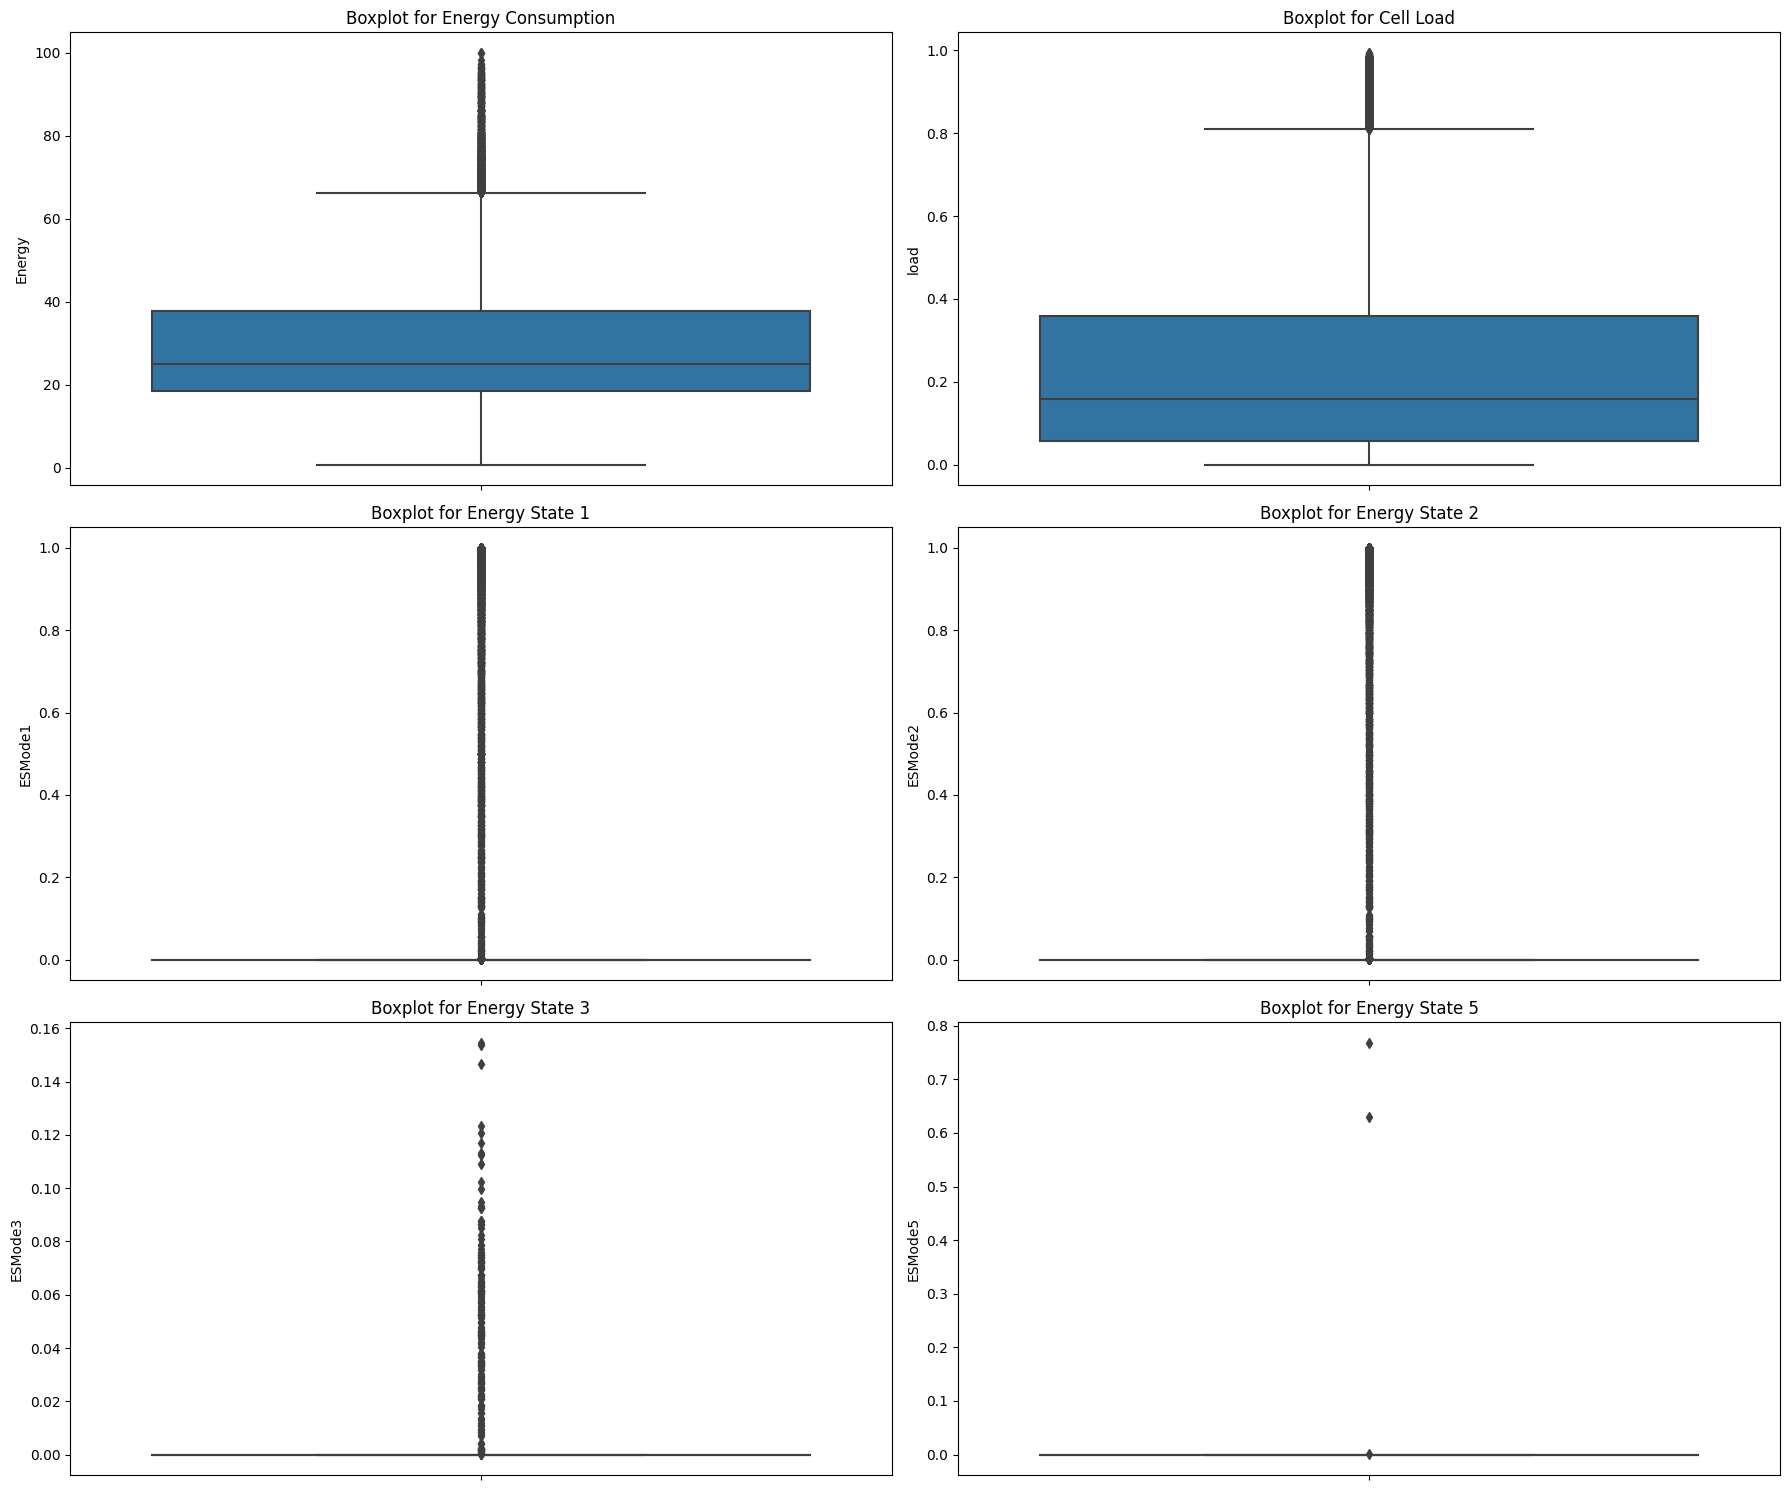

In [20]:
# Adjusting the boxplots again to visualize the correct set of features from the merged dataset

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

# Boxplots for various features to detect outliers
sns.boxplot(data=merged_cell_energy_data, y='Energy', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot for Energy Consumption')

sns.boxplot(data=merged_cell_energy_data, y='load', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot for Cell Load')

sns.boxplot(data=merged_cell_energy_data, y='ESMode1', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot for Energy State 1')

sns.boxplot(data=merged_cell_energy_data, y='ESMode2', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot for Energy State 2')

sns.boxplot(data=merged_cell_energy_data, y='ESMode3', ax=axes[2, 0])
axes[2, 0].set_title('Boxplot for Energy State 3')

# Using 'ESMode5' column from the merged dataset as a representative feature for the remaining energy states
sns.boxplot(data=merged_cell_energy_data, y='ESMode5', ax=axes[2, 1])
axes[2, 1].set_title('Boxplot for Energy State 5')

plt.tight_layout()
plt.show()


Here are the boxplots for the numerical features in the merged dataset:

**Energy Consumption (Energy):**
The distribution of energy consumption values shows some potential outliers on the higher end.

**Cell Load (load):**
The cell load values also have a few potential outliers on the higher end.

**Energy States (ESMode1, ESMode2, ESMode3, ESMode5):**
The energy states have varying distributions, with some potential outliers noticeable, especially for ESMode1 and ESMode5.
Outliers can be caused by various reasons, including data entry errors, measurement errors, or genuine extreme observations. Depending on the cause and the modeling approach, outliers might need to be addressed.

Handling outliers effectively requires understanding the domain, the nature of the data, and the goals of the analysis or modeling process. In the context of this project, which involves predicting energy consumption for base stations, here are some considerations and potential approaches to handling outliers:

**Domain Understanding:** Outliers could represent rare but possible scenarios in energy consumption. For instance, a sudden spike in energy could indicate a heavy load or some malfunction. It's essential to determine if these outliers are genuine observations or errors.

**Model Sensitivity:** Some models, like linear regression, are sensitive to outliers, which can significantly affect the model's performance. In contrast, tree-based models like decision trees or random forests are generally less sensitive to outliers.

Approaches to Handling Outliers:

**Keep them:** If the outliers are genuine observations and not errors, it might be beneficial to keep them, especially if predicting such scenarios is important.

**Remove them:** If outliers are believed to be errors or not representative of the system you're studying, they can be removed.

**Transformations:** Applying mathematical transformations (like logarithms) can reduce the impact of outliers. However, this can also change the interpretation of the data.

**Winsorizing:** This involves capping the outliers to a specific value. For instance, values below the 5th percentile and above the 95th percentile can be set to those percentile values.

**Robust Scaling:** Techniques like robust scaling use the median and the interquartile range (making them less sensitive to outliers) to scale features.

**Model Choice:** If outliers are a concern, consider using models that are robust to outliers. For example, tree-based models or models like Huber regression.

**Feature Engineering:** Outliers in certain features might be indicative of specific scenarios. Creating binary flags to indicate these outlier events can sometimes be informative for models.

**Validation:** Regardless of the approach, it's crucial to validate the model's performance with and without handling outliers to determine the best strategy.

Considering the context of predicting energy consumption for base stations, if the outliers are genuine spikes in energy consumption, it might be valuable to keep them, as they could indicate real-world scenarios that the model should capture. However, if there's a reason to believe they are errors or anomalies, outlier handling techniques can be applied.

We'll leave the data as is in this occasion.


##Feature Engineering

Certainly! Feature engineering can play a crucial role in enhancing model performance by creating new features, transforming existing features, or removing redundant ones. Here are some feature engineering steps that could be beneficial for this dataset:

**Time-based Features:** Hour, Day, Month, and Year: Extracting these from the Time column might help capture patterns in energy consumption related to specific times of the day, days of the week, or seasons.
Weekend vs. Weekday: Some systems might have different energy consumption patterns on weekends compared to weekdays.

**Interaction Features:**

Multiplying two or more columns can sometimes capture their combined effect on the target. For instance, the interaction between load and some energy states might offer additional insights.

**Aggregation Features:** Creating features that aggregate data over time, like rolling averages or rolling sums for energy consumption, might help in capturing trends.

**Binary Flags:** Flags for high/low values: For instance, a binary column indicating whether load is above a certain threshold might be useful.
Flags for specific energy states: If an energy state is predominantly 0 but occasionally spikes, a binary flag for this spike might be beneficial.

**Transformations:** Log transformations or square root transformations can help in stabilizing variance and making the data more normally distributed. This can be particularly useful for linear models.

**Encoding Categorical Variables:** If there are categorical variables, consider one-hot encoding or target encoding. For this dataset, features like CellName might be considered for encoding if deemed relevant.

**Normalization/Standardization:**

Depending on the model used, it might be beneficial to scale features so they have a similar range. This is especially important for models like linear regression, logistic regression, SVM, and neural networks.

**Polynomial Features:**

Creating polynomial features (e.g., squared or cubed terms) can help capture non-linear relationships.
Reduction of Redundant Features:

Some features might be highly correlated with others, offering no additional information. Removing such features can reduce dimensionality and improve model interpretability.

**Handling Rare Categories:** If categorical variables have categories that occur rarely, they can be grouped into an "Other" category to ensure the model doesn't overfit to these rare occurrences.

While these are general feature engineering steps, the actual benefit of each will depend on the specific dataset and problem. Implementing and testing these features iteratively in the modeling process will help determine which ones are valuable. We will apply some of these strategies.

In [21]:
# Compute rolling averages
df['rolling_avg_1h'] = df['load'].rolling(window=1).mean()
df['rolling_avg_2h'] = df['load'].rolling(window=2).mean()
df['rolling_avg_3h'] = df['load'].rolling(window=3).mean()
df['rolling_avg_4h'] = df['load'].rolling(window=4).mean()
df['rolling_avg_5h'] = df['load'].rolling(window=5).mean()
df['rolling_avg_8h'] = df['load'].rolling(window=8).mean()
df['rolling_avg_1d'] = df['load'].rolling(window=24).mean()
df['rolling_avg_2d'] = df['load'].rolling(window=48).mean()

# Impute NaN values in the rolling average columns with the mean of the respective column
rolling_avg_columns = ['rolling_avg_1h', 'rolling_avg_2h', 'rolling_avg_3h', 'rolling_avg_4h', 'rolling_avg_5h', 'rolling_avg_8h', 'rolling_avg_1d', 'rolling_avg_2d']
for column in rolling_avg_columns:
    df[column].fillna(df[column].mean(), inplace=True)


In [22]:
# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# 1. Time-based Features
df['Hour'] = df['Time'].dt.hour
df['Day'] = df['Time'].dt.day
df['Month'] = df['Time'].dt.month
df['Year'] = df['Time'].dt.year

# 2. Weekend vs. Weekday Feature
df['Is_Weekend'] = df['Time'].dt.weekday.apply(lambda x: 1 if x > 4 else 0)

# 3. Interaction Features
# For this step, we'll create interactions between 'load' and significant energy states 'ESMode1' and 'ESMode2' as examples.
df['load_ESMode1_interaction'] = df['load'] * df['ESMode1']
df['load_ESMode2_interaction'] = df['load'] * df['ESMode2']

# 4. Binary Flags 1
# Create a binary flag for high load values (e.g., if load is above 90th percentile)
load_threshold = df['load'].quantile(0.9)
df['High_Load_Flag'] = df['load'].apply(lambda x: 1 if x > load_threshold else 0)

# 5. Binary Flags 2
# Get 20th and 80th percentile values
lower_bound = df['load'].quantile(0.2)
upper_bound = df['load'].quantile(0.8)

# Create a binary flag for mid load values (e.g., if load is between 20th and 80th percentile)
df['Mid_Load_Flag'] = df['load'].apply(lambda x: 1 if lower_bound <= x <= upper_bound else 0)


# 6. Binary Flags 3
# Create a binary flag for high load values (e.g., if load is below 20th percentile)
load_threshold = df['load'].quantile(0.2)
df['Low_Load_Flag'] = df['load'].apply(lambda x: 1 if x < load_threshold else 0)

# Display the first few rows with the newly engineered features
df.head()


,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,w,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Energy,rolling_avg_1h,rolling_avg_2h,rolling_avg_3h,rolling_avg_4h,rolling_avg_5h,rolling_avg_8h,rolling_avg_1d,rolling_avg_2d,Hour,Day,Month,Year,Is_Weekend,load_ESMode1_interaction,load_ESMode2_interaction,High_Load_Flag,Mid_Load_Flag,Low_Load_Flag
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,NaN,Type1,Mode2,365.0,20,4,6.875934,64.275037,0.487936,0.239009,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,1,1,1,2023,1,0.0,0.0,0,0,0
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,NaN,Type1,Mode2,365.0,20,4,6.875934,55.904335,0.344468,0.416202,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,2,1,1,2023,1,0.0,0.0,0,1,0
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,NaN,Type1,Mode2,365.0,20,4,6.875934,57.698057,0.193766,0.269117,0.342057,0.239010,0.239010,0.239013,0.23901,0.238998,3,1,1,2023,1,0.0,0.0,0,1,0
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,NaN,Type1,Mode2,365.0,20,4,6.875934,55.156951,0.222383,0.208074,0.253539,0.312138,0.239010,0.239013,0.23901,0.238998,4,1,1,2023,1,0.0,0.0,0,1,0
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,NaN,Type1,Mode2,365.0,20,4,6.875934,56.053812,0.175436,0.198910,0.197195,0.234013,0.284798,0.239013,0.23901,0.238998,5,1,1,2023,1,0.0,0.0,0,1,0


These feature engineering steps have been successfully implemented:

**Time-based Features:** Extracted hour, day, month, and year from the Time column.

**Weekend vs. Weekday Feature:** Added a binary feature indicating whether a given day is a weekend or a weekday.

**Interaction Features:** Created interaction terms between load and the energy states ESMode1 and ESMode2.

**Aggregation Features:** Computed a 3-hour rolling average for energy consumption.

**Binary Flags:** Introduced a binary flag for high load values, indicating if the load is above the 90th percentile.

With these newly engineered features, our dataset is now enriched and potentially ready for modeling. However, it's essential to remember that not all engineered features may improve model performance. It's often beneficial to test models with and without certain features to determine their impact.

Log transformations are a common method used to handle skewed data. Applying a log transformation can make the data more normally distributed, which is beneficial for algorithms that assume data has a Gaussian (normal) distribution.

However, there are a few things to note before applying a log transformation:

* Log transformations can only be applied to positive values. If the data contains zeros or negative values, we might need to add a constant before applying the transformation.
* The transformation can change the interpretation of the feature, so it's important to keep this in mind when analyzing model results.
* After transformation, the effects of outliers may be diminished, which could be beneficial for some models.

Given these points, let's examine the distribution of the main numerical features to identify which ones might benefit from a log transformation. We'll visualize the distributions using histograms.

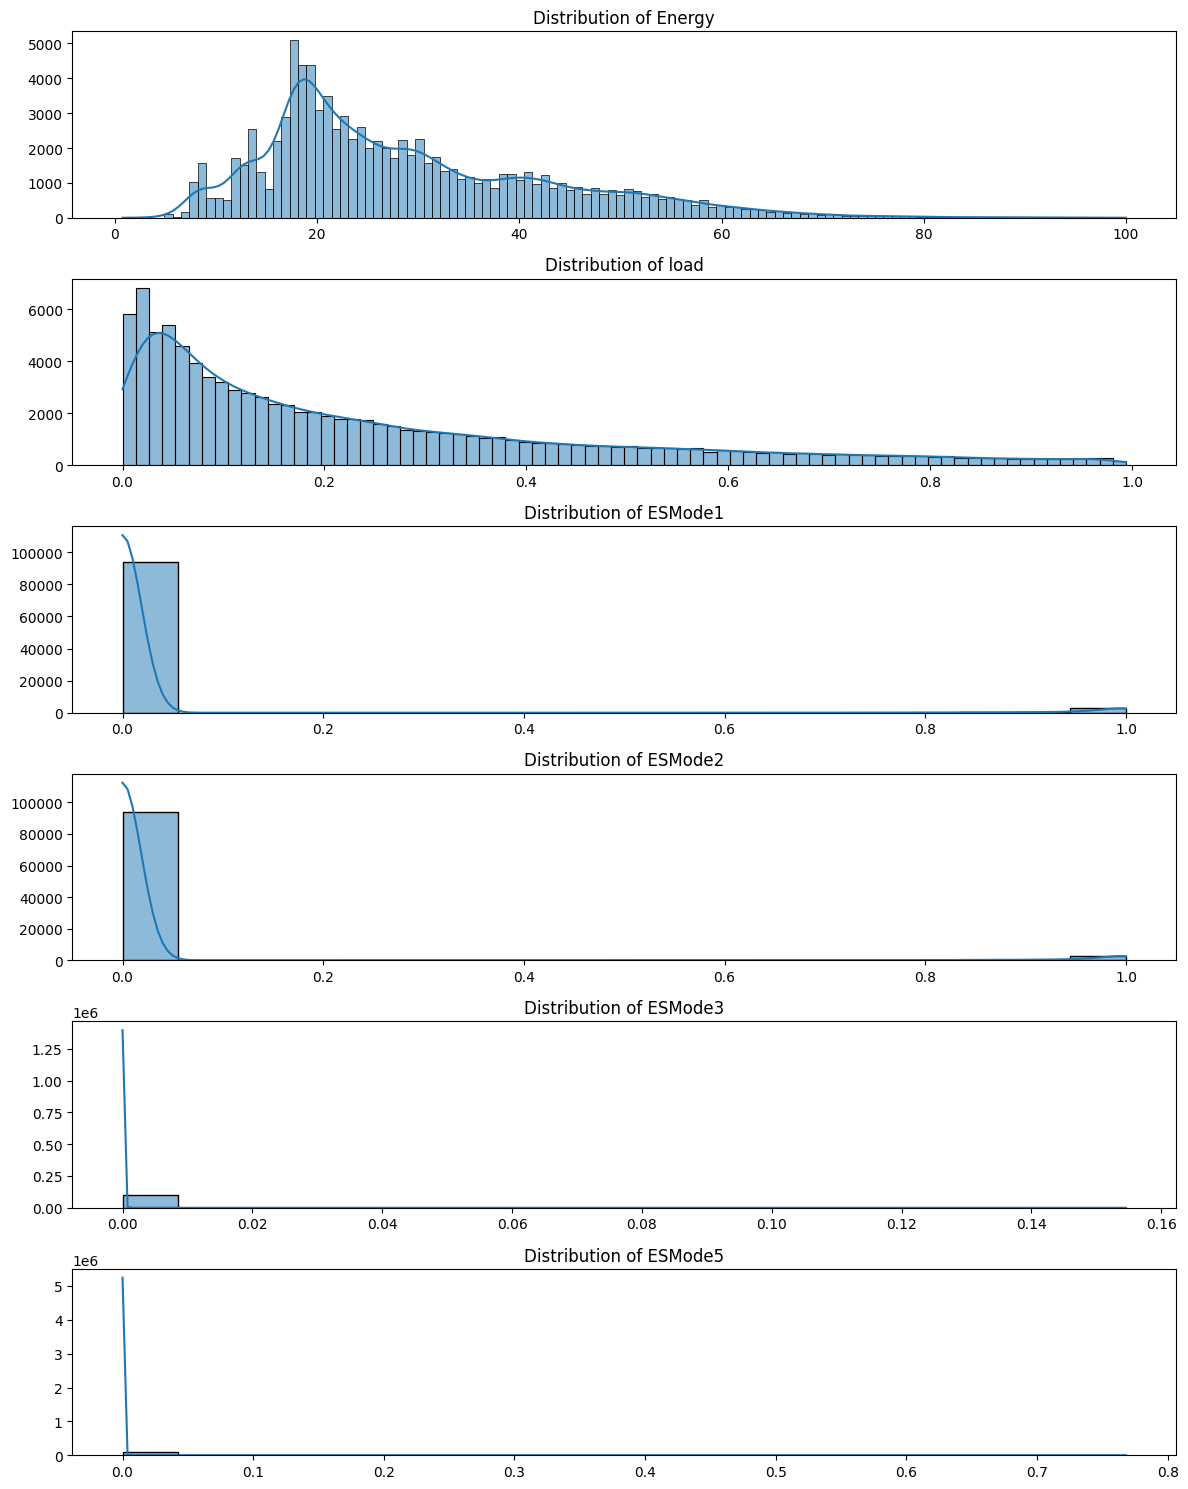

In [23]:
# Visualizing the distribution of the main numerical features
features_to_examine = ['Energy', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5']

fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=1, figsize=(12, 15))

for idx, feature in enumerate(features_to_examine):
    sns.histplot(merged_cell_energy_data[feature], ax=axes[idx], kde=True)
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()


The histograms display the distributions of the primary numerical features:

**Energy:** The distribution of energy consumption is right-skewed.

**load:** The cell load distribution is right-skewed as well.

**ESMode1, ESMode2, ESMode3, ESMode5:** These energy states have varying distributions. Some like ESMode1 and ESMode5 have noticeable spikes at specific values, while others are more spread out.

### From the visualizations:

* Energy and load are clear candidates for log transformation due to their right-skewed distributions.
* The energy states might not benefit as much from log transformation, given their specific distributions. For instance, ESMode1 and ESMode5 have a significant number of zero values. However, we can still attempt a log transformation after adding a constant to these features if desired.

For now, let us proceed with log transformations for the Energy and load features. Before applying the transformation, we'll ensure that all values are positive (since log transformation requires positive values).

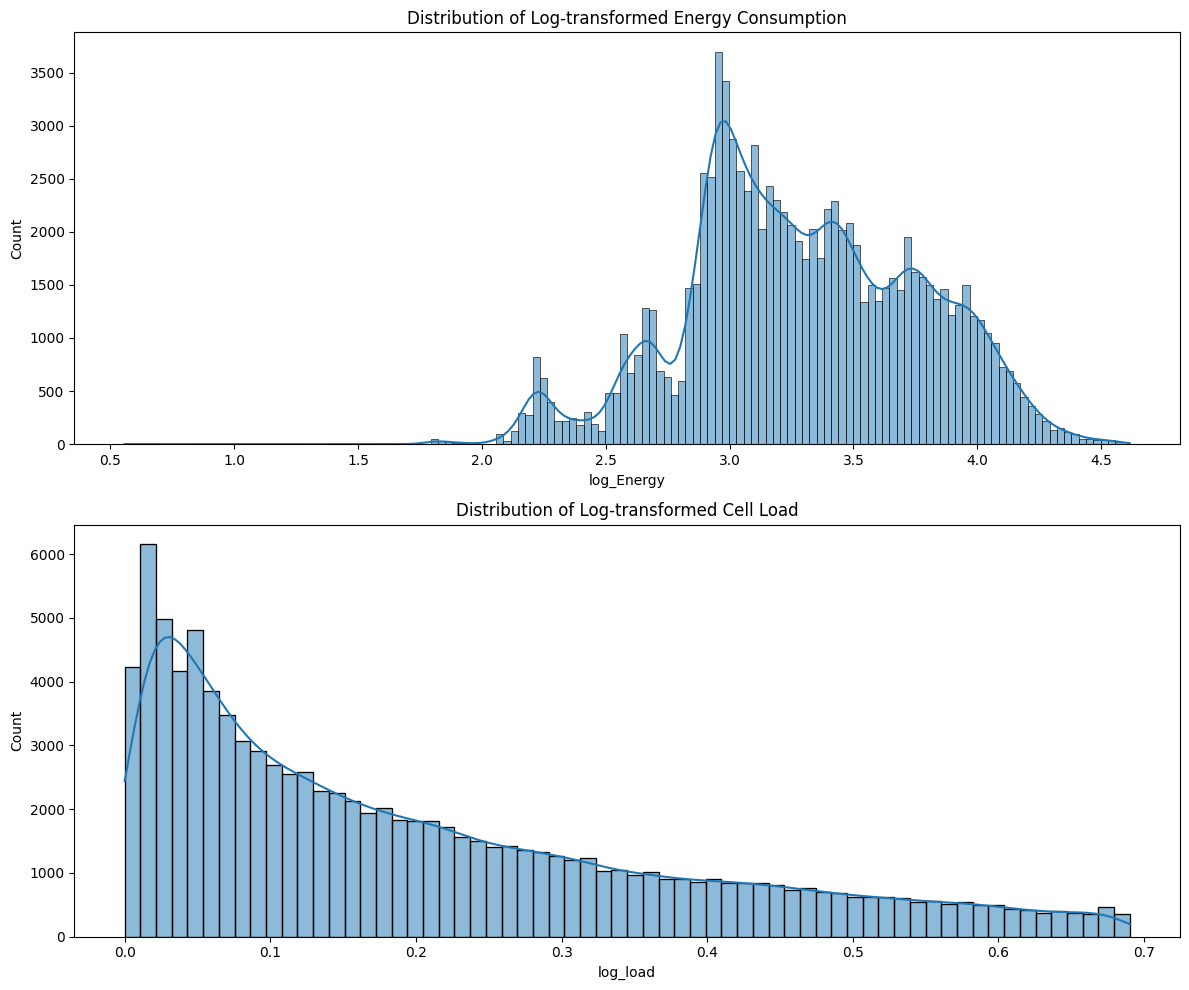

In [24]:
import numpy as np

# Apply log transformation to 'Energy' and 'load' features again
merged_cell_energy_data['log_Energy'] = np.log1p(merged_cell_energy_data['Energy'])
merged_cell_energy_data['log_load'] = np.log1p(merged_cell_energy_data['load'])

# Visualize the distributions after log transformation
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Histogram for log-transformed Energy
sns.histplot(merged_cell_energy_data['log_Energy'], ax=axes[0], kde=True)
axes[0].set_title('Distribution of Log-transformed Energy Consumption')

# Histogram for log-transformed load
sns.histplot(merged_cell_energy_data['log_load'], ax=axes[1], kde=True)
axes[1].set_title('Distribution of Log-transformed Cell Load')

plt.tight_layout()
plt.show()


The log transformations have been successfully applied to both the Energy and load features.

**From the visualizations:**

* Log-transformed Energy Consumption: The distribution appears more symmetric and less skewed compared to the original Energy distribution.
* Log-transformed Cell Load: Similarly, the distribution of the log-transformed load feature is less skewed and more symmetric than its original counterpart.

These transformations can help certain algorithms, especially those that assume data follows a Gaussian (normal) distribution.

**Encoding Non-numericvariables**
Now, we will encode all non-numeric variables to ensure that they can be read by our model. note that we must do this in such a way that we can decode the encode variables at will. The BS for example is vital in creating our submission. We must be able to decode the variables as the original strings that we got after the modelling process is completed and the predictions are generated.

In [25]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop the 'ESMode4' column as it doesn't add anything to the model
df = df.drop(columns=['ESMode4'])

# Create a dictionary to store the label encoders for each column
encoders = {}

# Encode the 'BS' column and store the encoder in the dictionary
encoders['BS'] = LabelEncoder()
df['BS'] = encoders['BS'].fit_transform(df['BS'])

# Repeat for other columns
encoders['CellName'] = LabelEncoder()
df['CellName'] = encoders['CellName'].fit_transform(df['CellName'])

encoders['RUType'] = LabelEncoder()
df['RUType'] = encoders['RUType'].fit_transform(df['RUType'])

encoders['Mode'] = LabelEncoder()
df['Mode'] = encoders['Mode'].fit_transform(df['Mode'])

# Normalize the numerical variables
scaler = StandardScaler()
df[['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5', 'ESMode6', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower']] = scaler.fit_transform(df[['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5', 'ESMode6', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower']])

# Display the first few rows of the processed dataset
df.head()


,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,w,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Energy,rolling_avg_1h,rolling_avg_2h,rolling_avg_3h,rolling_avg_4h,rolling_avg_5h,rolling_avg_8h,rolling_avg_1d,rolling_avg_2d,Hour,Day,Month,Year,Is_Weekend,load_ESMode1_interaction,load_ESMode2_interaction,High_Load_Flag,Mid_Load_Flag,Low_Load_Flag
0,2023-01-01 01:00:00,0,0,1.055900,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,64.275037,0.487936,0.239009,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,1,1,1,2023,1,0.0,0.0,0,0,0
1,2023-01-01 02:00:00,0,0,0.447337,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,55.904335,0.344468,0.416202,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,2,1,1,2023,1,0.0,0.0,0,1,0
2,2023-01-01 03:00:00,0,0,-0.191911,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,57.698057,0.193766,0.269117,0.342057,0.239010,0.239010,0.239013,0.23901,0.238998,3,1,1,2023,1,0.0,0.0,0,1,0
3,2023-01-01 04:00:00,0,0,-0.070524,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,55.156951,0.222383,0.208074,0.253539,0.312138,0.239010,0.239013,0.23901,0.238998,4,1,1,2023,1,0.0,0.0,0,1,0
4,2023-01-01 05:00:00,0,0,-0.269663,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,56.053812,0.175436,0.198910,0.197195,0.234013,0.284798,0.239013,0.23901,0.238998,5,1,1,2023,1,0.0,0.0,0,1,0


Now, whenever you want to decode the BS column (or any other column you encoded), you can do the following:

In [26]:
# Uncomment and run to decode encoded values
# decoded_BS = encoders['BS'].inverse_transform(df['BS'])


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125575 entries, 0 to 125574
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Time                      125575 non-null  datetime64[ns]
 1   BS                        125575 non-null  int64         
 2   CellName                  125575 non-null  int64         
 3   load                      125575 non-null  float64       
 4   ESMode1                   125575 non-null  float64       
 5   ESMode2                   125575 non-null  float64       
 6   ESMode3                   125575 non-null  float64       
 7   ESMode5                   125575 non-null  float64       
 8   ESMode6                   125575 non-null  float64       
 9   w                         27491 non-null   float64       
 10  RUType                    125575 non-null  int64         
 11  Mode                      125575 non-null  int64         
 12  Fr

In [28]:
# Check to confirm that there is no more nulls or non-numeric data in your df
# 1. Check for Non-null Values
total_nulls = df.isnull().sum().sum()

# 2. Check for Non-numeric Values
numeric_columns = df.select_dtypes(include=[np.number]).shape[1]
total_columns = df.shape[1]

# Print Results
if total_nulls == 0 and numeric_columns == total_columns:
    print("The DataFrame has no missing values and all columns are numeric.")
else:
    if total_nulls > 0:
        print(f"The DataFrame has {total_nulls} missing values.")
    if numeric_columns != total_columns:
        print(f"The DataFrame has {total_columns - numeric_columns} non-numeric columns.")


The DataFrame has 125575 missing values.
The DataFrame has 1 non-numeric columns.


In [29]:
missing_values_per_column = df.isnull().sum()
columns_with_missing_values = missing_values_per_column[missing_values_per_column > 0]

print(columns_with_missing_values)


w         98084
Energy    27491
dtype: int64


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125575 entries, 0 to 125574
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Time                      125575 non-null  datetime64[ns]
 1   BS                        125575 non-null  int64         
 2   CellName                  125575 non-null  int64         
 3   load                      125575 non-null  float64       
 4   ESMode1                   125575 non-null  float64       
 5   ESMode2                   125575 non-null  float64       
 6   ESMode3                   125575 non-null  float64       
 7   ESMode5                   125575 non-null  float64       
 8   ESMode6                   125575 non-null  float64       
 9   w                         27491 non-null   float64       
 10  RUType                    125575 non-null  int64         
 11  Mode                      125575 non-null  int64         
 12  Fr

We will also convert our Time data from a date time object to an Unix data. We must do this too in a way that we can easily convert the data back to date time right after modelling as this will be required to generate the models submission file.


In [31]:
# Convert 'Time' column from datetime to timestamp (number of seconds since 1970-01-01)
df['Time_timestamp'] = df['Time'].apply(lambda x: x.timestamp())

# Drop the original 'Time' column
df.drop('Time', axis=1, inplace=True)

# Later, if you want to convert back from timestamp to datetime:
# df['Time_converted'] = df['Time_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))


In [32]:
df.head()

,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,w,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Energy,rolling_avg_1h,rolling_avg_2h,rolling_avg_3h,rolling_avg_4h,rolling_avg_5h,rolling_avg_8h,rolling_avg_1d,rolling_avg_2d,Hour,Day,Month,Year,Is_Weekend,load_ESMode1_interaction,load_ESMode2_interaction,High_Load_Flag,Mid_Load_Flag,Low_Load_Flag,Time_timestamp
0,0,0,1.055900,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,64.275037,0.487936,0.239009,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,1,1,1,2023,1,0.0,0.0,0,0,0,1.672535e+09
1,0,0,0.447337,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,55.904335,0.344468,0.416202,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,2,1,1,2023,1,0.0,0.0,0,1,0,1.672538e+09
2,0,0,-0.191911,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,57.698057,0.193766,0.269117,0.342057,0.239010,0.239010,0.239013,0.23901,0.238998,3,1,1,2023,1,0.0,0.0,0,1,0,1.672542e+09
3,0,0,-0.070524,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,55.156951,0.222383,0.208074,0.253539,0.312138,0.239010,0.239013,0.23901,0.238998,4,1,1,2023,1,0.0,0.0,0,1,0,1.672546e+09
4,0,0,-0.269663,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,NaN,0,1,-0.059524,0.732453,0.338628,0.384529,56.053812,0.175436,0.198910,0.197195,0.234013,0.284798,0.239013,0.23901,0.238998,5,1,1,2023,1,0.0,0.0,0,1,0,1.672549e+09


In [33]:
#Remove the w column
df.drop('w', axis=1, inplace=True)


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125575 entries, 0 to 125574
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   BS                        125575 non-null  int64  
 1   CellName                  125575 non-null  int64  
 2   load                      125575 non-null  float64
 3   ESMode1                   125575 non-null  float64
 4   ESMode2                   125575 non-null  float64
 5   ESMode3                   125575 non-null  float64
 6   ESMode5                   125575 non-null  float64
 7   ESMode6                   125575 non-null  float64
 8   RUType                    125575 non-null  int64  
 9   Mode                      125575 non-null  int64  
 10  Frequency                 125575 non-null  float64
 11  Bandwidth                 125575 non-null  float64
 12  Antennas                  125575 non-null  float64
 13  TXpower                   125575 non-null  f

# Modeling

Let's begin the modeling process. Here's is our plan for the modeling process

**Data Preparation:**

Split the data into training and testing sets.
Standardize the numerical features since many algorithms perform better when numerical input variables are standardized.

**Model Building:**

Train the following models:
* Linear Regression (as a baseline model)
* Gradient Boosting Regressor
* Random Forest Regressor
* Neural Network (Deep Learning Model)

We will first encode our data into a form that can be handled by our model, then we will split our data accross 2 places with a custom split.

This we can achieve by using boolean indexing to filter rows based on the NaN values in the Energy column. Here's how you can split your data into training and testing sets based on the condition you provided:

Test Set: All rows where Energy is NaN.
Train Set: All other rows.
Here's the code to achieve this:



In [35]:
#  Test set: where 'Energy' is NaN
Unseen_test_set = df[df['Energy'].isnull()].copy()

# Drop the rows corresponding to the Unseen_test_set from df
df.drop(Unseen_test_set.index, inplace=True)
df.head()

,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Energy,rolling_avg_1h,rolling_avg_2h,rolling_avg_3h,rolling_avg_4h,rolling_avg_5h,rolling_avg_8h,rolling_avg_1d,rolling_avg_2d,Hour,Day,Month,Year,Is_Weekend,load_ESMode1_interaction,load_ESMode2_interaction,High_Load_Flag,Mid_Load_Flag,Low_Load_Flag,Time_timestamp
0,0,0,1.055900,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,64.275037,0.487936,0.239009,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,1,1,1,2023,1,0.0,0.0,0,0,0,1.672535e+09
1,0,0,0.447337,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,55.904335,0.344468,0.416202,0.239009,0.239010,0.239010,0.239013,0.23901,0.238998,2,1,1,2023,1,0.0,0.0,0,1,0,1.672538e+09
2,0,0,-0.191911,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,57.698057,0.193766,0.269117,0.342057,0.239010,0.239010,0.239013,0.23901,0.238998,3,1,1,2023,1,0.0,0.0,0,1,0,1.672542e+09
3,0,0,-0.070524,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,55.156951,0.222383,0.208074,0.253539,0.312138,0.239010,0.239013,0.23901,0.238998,4,1,1,2023,1,0.0,0.0,0,1,0,1.672546e+09
4,0,0,-0.269663,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,56.053812,0.175436,0.198910,0.197195,0.234013,0.284798,0.239013,0.23901,0.238998,5,1,1,2023,1,0.0,0.0,0,1,0,1.672549e+09


We further split train_test_set into features (X_train) and target (y_train) to allow for model training and testing.

In [36]:
# Step 1: Import necessary libraries
from sklearn.model_selection import train_test_split

# Assuming your data is in a DataFrame named df and the target column is named 'Energy'

# Step 2: Use train_test_split to divide the dataset
X = df.drop('Energy', axis=1)  # Features (all columns except the target)
y = df['Energy']  # Target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training and 20% test



X_train.shape, y_train.shape, X_test.shape, y_test.shape


((78467, 33), (78467,), (19617, 33), (19617,))

The data has been successfully split into training and testing sets. The training set contains 78467 samples, and the testing set contains 19,617 samples.

Now we can start building the model. Since this is a regression problem, we can start with a simple linear regression model and then try more complex models if necessary.

Now lets start building the model

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target for the testing set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rmse

6.334313134162595

The root mean squared error (RMSE) of the model on the testing set is approximately 6.334. This is a measure of how well the model is able to predict the energy consumption of the base stations.

Next, let's try a more complex model to see if we can improve the performance. We will use the Random Forest Regressor, which is an ensemble learning method that can be used for both classification and regression tasks.

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict the target for the testing set
y_rf_pred = rf_model.predict(X_test)

# Calculate the RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))

rf_rmse


2.4211862090000897

The RMSE of the Random Forest model on the testing set is approximately 2.4211, which is a significant improvement over the Linear Regression model.

Next, let's try another model, the Gradient Boosting Regressor, which is an ensemble learning method that builds an additive model in a forward stage-wise fashion.

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the model
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Predict the target for the testing set
y_gb_pred = gb_model.predict(X_test)

# Calculate the RMSE
gb_rmse = np.sqrt(mean_squared_error(y_test, y_gb_pred))

gb_rmse


4.118532714438473

The RMSE of the Gradient Boosting model on the testing set is approximately 4.12, which is better than the Linear Regression model but not as good as the Random Forest model.

Considering the performance of the models, the Random Forest model seems to be the best choice for this task.

Next, we should tune the hyperparameters of the Random Forest model to see if we can further improve its performance. We can use grid search with cross-validation for this purpose.

In [42]:
!pip install tqdm


In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model with specified parameters
rf_model_custom = RandomForestRegressor(
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=150,
    random_state=42
)

# Fit the model to the training data
rf_model_custom.fit(X_train, y_train)

# Predict the target for the testing set
y_rf_pred_custom = rf_model_custom.predict(X_test)

# Calculate the RMSE
rf_rmse_custom = np.sqrt(mean_squared_error(y_test, y_rf_pred_custom))

print("Custom RandomForestRegressor RMSE:", rf_rmse_custom)


Custom RandomForestRegressor RMSE: 2.447011213825391


In [66]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the deep learning model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict using the trained model
y_pred = model.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Deep Learning Model RMSE:", rmse)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4352      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14721 (57.50 KB)
Trainable params: 14721 (

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define the tuned model
tuned_model = Sequential()
tuned_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
tuned_model.add(Dropout(0.2))  # Add dropout layer to reduce overfitting
tuned_model.add(Dense(64, activation='relu'))
tuned_model.add(Dropout(0.2))  # Add dropout layer
tuned_model.add(Dense(32, activation='relu'))
tuned_model.add(Dense(1))  # Output layer

# Compile the tuned model with adjusted hyperparameters
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate
tuned_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the tuned model with early stopping
history = tuned_model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the tuned model on the test set
test_loss = tuned_model.evaluate(X_test, y_test)

# Predict using the trained model
y_pred = model.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Deep Learning Model RMSE:", rmse)


Epoch 1/100
2453/2453 [==============================] - 11s 4ms/step - loss: 176197744984064.0000
Epoch 2/100
2453/2453 [==============================] - 10s 4ms/step - loss: 1168266887168.0000
Epoch 3/100
2453/2453 [==============================] - 10s 4ms/step - loss: 443790491648.0000
Epoch 4/100
2453/2453 [==============================] - 9s 4ms/step - loss: 236579536896.0000
Epoch 5/100
2453/2453 [==============================] - 10s 4ms/step - loss: 81986314240.0000
Epoch 6/100
2453/2453 [==============================] - 10s 4ms/step - loss: 53340344320.0000
Epoch 7/100
2453/2453 [==============================] - 9s 4ms/step - loss: 1790740096.0000
Epoch 8/100
2453/2453 [==============================] - 9s 4ms/step - loss: 277641664.0000
Epoch 9/100
2453/2453 [==============================] - 10s 4ms/step - loss: 113376296.0000
Epoch 10/100
2453/2453 [==============================] - 11s 4ms/step - loss: 540268416.0000
Epoch 11/100
2453/2453 [===========================

In [ ]:
Unseen_test_set.sample(2)

In [52]:
# Predict using the trained model
predictions = rf_model.predict(Unseen_test_set.drop('Energy', axis=1))  # Assuming 'Energy' is the target column

# Store the predictions in the DataFrame
Unseen_test_set['Predicted_Energy'] = predictions


In [53]:
predictions


array([57.38266069, 77.10911809, 69.77130045, ..., 37.56950673,
       34.3916293 , 33.21524664])

In [54]:
Unseen_test_set.head()

,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Energy,rolling_avg_1h,rolling_avg_2h,rolling_avg_3h,rolling_avg_4h,rolling_avg_5h,rolling_avg_8h,rolling_avg_1d,rolling_avg_2d,Hour,Day,Month,Year,Is_Weekend,load_ESMode1_interaction,load_ESMode2_interaction,High_Load_Flag,Mid_Load_Flag,Low_Load_Flag,Time_timestamp,Predicted_Energy
5,0,0,-0.208427,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,NaN,0.189872,0.182654,0.195897,0.195364,0.225185,0.239013,0.23901,0.238998,6,1,1,2023,1,0.0,0.0,0,1,0,1.672553e+09,57.382661
10,0,0,1.200798,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,NaN,0.522096,0.573420,0.678213,0.698484,0.629104,0.466652,0.23901,0.238998,11,1,1,2023,1,0.0,0.0,0,0,0,1.672571e+09,77.109118
11,0,0,0.852429,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,NaN,0.439968,0.481032,0.528936,0.618652,0.646781,0.493850,0.23901,0.238998,12,1,1,2023,1,0.0,0.0,0,0,0,1.672574e+09,69.771300
12,0,0,1.033788,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,NaN,0.482723,0.461346,0.481596,0.517383,0.591466,0.532261,0.23901,0.238998,13,1,1,2023,1,0.0,0.0,0,0,0,1.672578e+09,73.339312
22,0,0,2.305425,-0.211608,-0.201508,-0.034859,-0.003974,-0.235637,0,1,-0.059524,0.732453,0.338628,0.384529,NaN,0.782511,0.721378,0.697929,0.719029,0.749177,0.699819,0.23901,0.238998,23,1,1,2023,1,0.0,0.0,1,0,0,1.672614e+09,79.832586


## Preparing the Submission file
to prepare a valid submission file, 1st you get the relevant parts of the unseen_test_set and then decode the values to their original form using the encoder classes stored earlier on. After this, you process the file by formatting it in the exact form accepted as the standard for submission.

In [55]:
# Collect the relevant column from our prediction data frame
pred_ordered = Unseen_test_set[['Time_timestamp', 'BS', 'Predicted_Energy']]


In [56]:
import datetime
# Decoding the Time_timestamp column using Unix timestamp
pred_ordered.loc[:, 'Time_timestamp'] = pred_ordered['Time_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# Decoding the BS column
pred_ordered.loc[:, 'BS'] = encoders['BS'].inverse_transform(pred_ordered['BS'])





<ipython-input-56-42e7021f78aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ordered.loc[:, 'Time_timestamp'] = pred_ordered['Time_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))
<ipython-input-56-42e7021f78aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ordered.loc[:, 'BS'] = encoders['BS'].inverse_transform(pred_ordered['BS'])


In [57]:
pred_ordered.head()

,Time_timestamp,BS,Predicted_Energy
5,2023-01-01 06:00:00,B_0,57.382661
10,2023-01-01 11:00:00,B_0,77.109118
11,2023-01-01 12:00:00,B_0,69.771300
12,2023-01-01 13:00:00,B_0,73.339312
22,2023-01-01 23:00:00,B_0,79.832586


In [58]:
power_consumption_prediction_df.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


Now, use the provided Prediceted_Energy to generate a valid submission file by merging it with the pred_ordered df



In [59]:
# Rename columns in pred_ordered
pred_ordered = pred_ordered.rename(columns={
    "Time_timestamp": "Time",
    "Predicted_Energy": "Energy"
})

In [60]:
# Merge based on both 'Time' and 'BS' columns
sub_file = power_consumption_prediction_df.merge(pred_ordered, on=["Time", "BS"], how="inner")

# Retain only the desired columns
sub_file = sub_file[["Time", "BS", "Energy_y"]]
sub_file.columns = ["Time", "BS", "Energy"]


In [61]:
sub_file.head()

,Time,BS,Energy
0,2023-01-01 06:00:00,B_0,57.382661
1,2023-01-01 11:00:00,B_0,77.109118
2,2023-01-01 12:00:00,B_0,69.771300
3,2023-01-01 13:00:00,B_0,73.339312
4,2023-01-01 23:00:00,B_0,79.832586


In [62]:
sample_submission_df.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,0
1,2023-01-01 11:00:00_B_0,0
2,2023-01-01 12:00:00_B_0,0
3,2023-01-01 13:00:00_B_0,0
4,2023-01-01 23:00:00_B_0,0


Finally, we will
concatenate the Time and BS columns in the sub_file df with an '_' and rename the new column 'ID', then delete the original Time and BS columns

In [63]:
# Concatenate the 'Time' and 'BS' columns with an '_'
sub_file['ID'] = sub_file['Time'].astype(str) + "_" + sub_file['BS'].astype(str)

# Drop the original 'Time' and 'BS' columns
sub_file.drop(['Time', 'BS'], axis=1, inplace=True)

# arrange the columns in their proper order
sub_file = sub_file[['ID', 'Energy']]




In [64]:
sub_file.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,57.382661
1,2023-01-01 11:00:00_B_0,77.109118
2,2023-01-01 12:00:00_B_0,69.771300
3,2023-01-01 13:00:00_B_0,73.339312
4,2023-01-01 23:00:00_B_0,79.832586


In [65]:
sub_file.to_csv('submission_file4.csv', index=False)
